In [49]:
import math
from random import seed
import os
import pandas as pd
from itertools import combinations
import scipy.cluster.hierarchy as sch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import hypergeom
from sklearn.preprocessing import StandardScaler
from collections import Counter
from scipy.cluster import hierarchy
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
import xlsxwriter

In [50]:
#Read all SNP files from FUMA analysis

# Directory path
directory_path = 'FUMA_dowloads_all_tissue/SNPs'

snp_df_list = []
disorder_names = []

# Iterate through files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.txt'):  # Process only .txt files
        # Extract disorder name from the filename
        disorder_name = filename.split('_')[1].split('.')[0]
        disorder_names.append(disorder_name)

        # Read the file as a DataFrame
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path, sep='\t')

        # Choose columns of interest
        df['disorder'] = disorder_name
        df = df[['uniqID','rsID','gwasP','disorder']]
        df = df.dropna()
        df.reset_index(inplace=True, drop=True)
        # Append the DataFrame to the list
        snp_df_list.append(df)

In [51]:
# Split data into psychiatric and other
valid_strings = ['ADHD','ANOREXIA','ANXIETY','ASD','AUD','BPD','CUD','HOARDING','MDD','OCD','PTSD','SZC','TOURETTES']

psych_snp_dfs = []
other_snp_dfs = []

for df in snp_df_list:
    # Check if any valid string is present in the 'disorder' column
    if any(df['disorder'].str.contains(valid_string).any() for valid_string in valid_strings):
        # If at least one valid string is present, append the dataframe to psych_snps_dfs
        psych_snp_dfs.append(df)
    else:
        # If no valid string is present, append the dataframe to other_snp_dfs
        other_snp_dfs.append(df)

In [52]:
print(len(psych_snp_dfs), len(other_snp_dfs))

13 12


In [53]:
#Read all eQTL files from FUMA analysis

# Directory path
directory_path = 'FUMA_dowloads_all_tissue/eQTL'


gene_df_list = []
disorder_names = []

# Iterate through files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.txt'):  # Process only .txt files
        # Extract disorder name from the filename
        disorder_name = filename.split('_')[1].split('.')[0]
        disorder_names.append(disorder_name)

        # Read the file as a DataFrame
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path, sep='\t', low_memory=False)

        # Choose columns of interest
        df['disorder'] = disorder_name
        df = df[['uniqID','symbol','tissue','disorder']]
        df = df.dropna()
        df.reset_index(inplace=True, drop=True)
        # Append the DataFrame to the list
        gene_df_list.append(df)

In [54]:
#Split data into psychiatric and other
psych_genes_dfs = []
other_genes_dfs = []

for df in gene_df_list:
    # Check if any valid string is present in the 'disorder' column
    if any(df['disorder'].str.contains(valid_string).any() for valid_string in valid_strings):
        # If at least one valid string is present, append the dataframe to psych_genes_dfs
        psych_genes_dfs.append(df)
    else:
        # If no valid string is present, append the dataframe to other_genes_dfs
        other_genes_dfs.append(df)

In [55]:
other_genes_dfs[0]

,uniqID,symbol,tissue,disorder
0,1:2252400:A:AG,MORN1,Nom_Alonso_Pancreatic_islets,ARTHRITIS
1,1:2483961:A:G,TNFRSF14,Nom_Alonso_Pancreatic_islets,ARTHRITIS
2,1:2501222:G:T,TNFRSF14,Nom_Alonso_Pancreatic_islets,ARTHRITIS
3,1:2507415:G:T,TNFRSF14,Nom_Alonso_Pancreatic_islets,ARTHRITIS
4,1:2516781:A:G,TNFRSF14,Nom_Alonso_Pancreatic_islets,ARTHRITIS
...,...,...,...,...
1604851,22:21976934:C:T,CCDC116,Vagina,ARTHRITIS
1604852,22:21979096:C:T,CCDC116,Vagina,ARTHRITIS
1604853,22:21982249:C:T,CCDC116,Vagina,ARTHRITIS
1604854,22:21983260:A:G,CCDC116,Vagina,ARTHRITIS


In [56]:
""" # extract all genes from each disorder and save to file
output_folder = 'genes_to_EnrichR'
os.makedirs(output_folder, exist_ok=True)

# Iterate through each dataframe
for df in gene_df_list:
    # Extract disorder name
    disorder_name = df['disorder'].iloc[0] 
    
    # Extract unique symbols and save to txt file
    unique_symbols = df['symbol'].drop_duplicates().tolist()
    output_file = os.path.join(output_folder, f"{disorder_name}.txt")
    with open(output_file, 'w') as f:
        for symbol in unique_symbols:
            f.write(f"{symbol}\n") """

' # extract all genes from each disorder and save to file\noutput_folder = \'genes_to_EnrichR\'\nos.makedirs(output_folder, exist_ok=True)\n\n# Iterate through each dataframe\nfor df in gene_df_list:\n    # Extract disorder name\n    disorder_name = df[\'disorder\'].iloc[0] \n    \n    # Extract unique symbols and save to txt file\n    unique_symbols = df[\'symbol\'].drop_duplicates().tolist()\n    output_file = os.path.join(output_folder, f"{disorder_name}.txt")\n    with open(output_file, \'w\') as f:\n        for symbol in unique_symbols:\n            f.write(f"{symbol}\n") '

In [57]:
#merge SNP and gene dataframes to map SNPs to genes
merged_list = []
for i in range(len(snp_df_list)):
    merged_df = pd.merge(snp_df_list[i], gene_df_list[i], on=['uniqID'], how='inner')
    #print(merged_df.head())
    merged_df.drop(columns=['disorder_x'], inplace=True)
    merged_df = merged_df[['uniqID','rsID','symbol','tissue','disorder_y']]
    merged_df = merged_df.rename(columns={'symbol':'gene','disorder_y': 'disorder'})
    merged_df.drop_duplicates(inplace=True)
    merged_list.append(merged_df)
all_merged = pd.concat(merged_list)

In [58]:
#Function to make binary matrix of SNPs and disorders
def make_binary_snp_matrix(df_list):
    concatenated= pd.concat(df_list)
    snp_df = concatenated[['rsID', 'disorder']]
    
    return snp_df.pivot_table(index='rsID', columns='disorder', aggfunc=lambda x: 1, fill_value=0)
    

In [59]:
#Function to make binary matrix of genes and disorders
def make_binary_gene_matrix(df_list):
    concatenated= pd.concat(df_list)
    gene_df = concatenated[['symbol', 'disorder']]
    
    return gene_df.pivot_table(index='symbol', columns='disorder', aggfunc=lambda x: 1, fill_value=0)

In [60]:
#Make a binary matrix of all snps to find out how many there are in each disorder
all_snps_binary = make_binary_snp_matrix(snp_df_list)
all_genes_binary = make_binary_gene_matrix(gene_df_list)
psych_snps_binary = make_binary_snp_matrix(psych_snp_dfs)
genes_psych_binary = make_binary_gene_matrix(psych_genes_dfs)
# snps_other_binary = make_binary_SNPs_matrix(dfs_other)
# print('The number of SNPs shared between at least 2 disorders: ', (snps_psych_binary.sum(axis=1) >= 2).sum())



In [61]:
print(all_snps_binary.sum(axis=0))


disorder
ADHD           7018
ANOREXIA       2562
ANXIETY          84
ARTHRITIS     13819
ASD            4006
AUD            5984
BIL            9791
BPD           27077
CUD             719
EPILEPSY        462
FATIGUE         193
GOUT            269
HOARDING         79
IBS             432
LUPUS         17546
MDD           15332
MIGRAINE       2583
MS             1302
MYASTHENIA      713
OCD             130
PARKINSONS     5508
PTSD            186
SJOGRENS        621
SZC           41691
TOURETTES       292
dtype: int64


In [62]:
print(all_genes_binary.sum(axis=0))
#all_genes_binary.to_csv('all_genes_binary.csv')

disorder
ADHD          1135
ANOREXIA       474
ANXIETY         43
ARTHRITIS     2660
ASD            308
AUD            678
BIL           2434
BPD           2440
CUD            308
EPILEPSY        28
FATIGUE         73
GOUT           325
HOARDING        42
IBS             23
LUPUS         1888
MDD           1485
MIGRAINE       566
MS            1579
MYASTHENIA     502
OCD             44
PARKINSONS     802
PTSD           128
SJOGRENS        71
SZC           4149
TOURETTES      164
dtype: int64


In [63]:
all_snps_binary.to_csv('all_snps_binary.txt', sep='\t')
all_genes_binary.to_csv('all_genes_binary.txt', sep='\t')

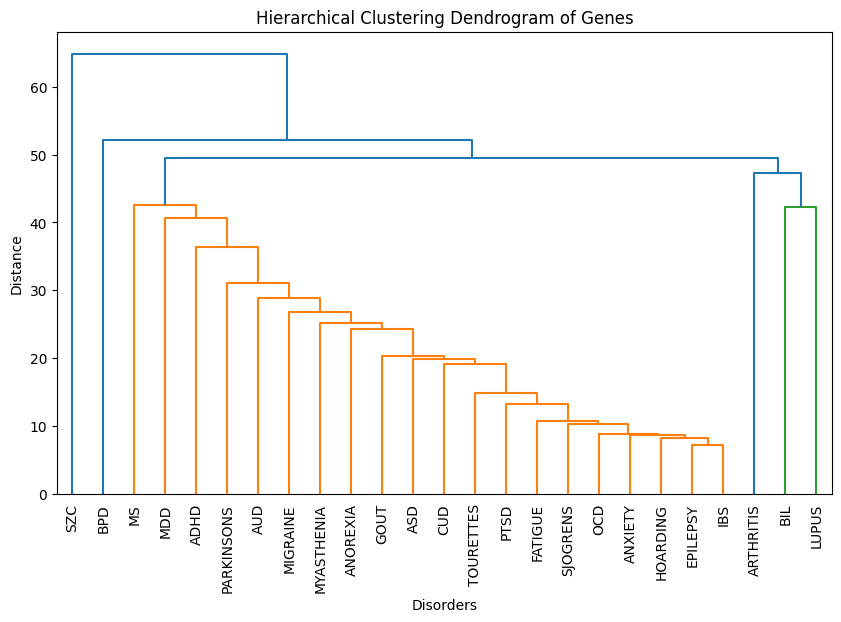

In [64]:
# Hierarchical clustering
linkage_matrix = hierarchy.linkage(all_genes_binary.T, method='average')


# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram = hierarchy.dendrogram(linkage_matrix, labels=all_snps_binary.columns)
plt.xlabel('Disorders')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram of Genes')
plt.xticks(rotation=90)
plt.show() 

In [65]:
max_ones_count = genes_psych_binary.sum(axis=1).max()
print(max_ones_count)

7


In [66]:
def count_combos(binary_df):
# Set a seed for reproducibility
    np.random.seed(42)

    num_iterations = 10

    # Get all possible combinations of disorders
    all_combinations = []
    for r in range(2,6):
        all_combinations.extend(list(combinations(binary_df.columns, r)))

    # Create an empty DataFrame with rows as each combination and columns for storing counts in each iteration
    counts_df = pd.DataFrame(index=all_combinations, columns=range(1,num_iterations+1))

    # Perform the iterations
    for i in range(1,num_iterations+1):
        # Permute the columns independently
        permuted_df = binary_df.apply(np.random.permutation, axis=0)

        iteration_counts = []

        # Count occurrences for each combination in this iteration
        for combo in all_combinations:
            # Check if all disorders in the combination are present in each row
            count = (permuted_df[list(combo)] == 1).all(axis=1).sum()
            iteration_counts.append(count)

        # Store the counts for this iteration in the dataFrame
        counts_df[i] = iteration_counts

    return counts_df

In [67]:
def count_combos_real_data(binary_df):
#Count all occurrences for each combination and store in a new dataframe

    # Get all possible combinations of disorders 
    all_combinations = []
    for r in range(2,6):
        all_combinations.extend(list(combinations(binary_df.columns, r)))
        
    #Create empty dataframe to store the count
    count_df = pd.DataFrame(index=all_combinations, columns=['Count'])

    iteration_counts = []

    # Count occurrences for each combination in this iteration 
    for combo in all_combinations:
        # Check if all disorders in the combination are present in each row
        count = (binary_df[list(combo)] == 1).all(axis=1).sum()
        iteration_counts.append(count)

    # Store the counts for this iteration in the counts_df DataFrame
    count_df['Count'] = iteration_counts
    
    return count_df


In [68]:

psych_snps_randomized = count_combos(psych_snps_binary)
all_snps_randomized = count_combos(all_snps_binary)
psych_genes_randomized = count_combos(genes_psych_binary)
all_genes_randomized = count_combos(all_genes_binary)


In [69]:
psych_genes_randomized

,1,2,3,4,5,6,7,8,9,10
"(ADHD, ANOREXIA)",69,81,60,72,76,78,71,75,81,67
"(ADHD, ANXIETY)",11,5,15,9,10,3,4,5,2,5
"(ADHD, ASD)",59,50,57,59,52,51,51,46,44,48
"(ADHD, AUD)",108,120,112,102,118,115,117,105,111,111
"(ADHD, BPD)",361,405,392,384,399,380,388,406,391,391
...,...,...,...,...,...,...,...,...,...,...
"(HOARDING, MDD, OCD, PTSD, TOURETTES)",0,0,0,0,0,0,0,0,0,0
"(HOARDING, MDD, OCD, SZC, TOURETTES)",0,0,0,0,0,0,0,0,0,0
"(HOARDING, MDD, PTSD, SZC, TOURETTES)",0,0,0,0,0,0,0,0,0,0
"(HOARDING, OCD, PTSD, SZC, TOURETTES)",0,0,0,0,0,0,0,0,0,0


In [70]:
psych_snps_combo_count = count_combos_real_data(psych_snps_binary)
all_snps_combo_count = count_combos_real_data(all_snps_binary)
psych_genes_combo_count = count_combos_real_data(genes_psych_binary)
all_genes_combo_count = count_combos_real_data(all_genes_binary)


In [71]:
psych_genes_combo_count

,Count
"(ADHD, ANOREXIA)",168
"(ADHD, ANXIETY)",2
"(ADHD, ASD)",35
"(ADHD, AUD)",94
"(ADHD, BPD)",247
...,...
"(HOARDING, MDD, OCD, PTSD, TOURETTES)",0
"(HOARDING, MDD, OCD, SZC, TOURETTES)",0
"(HOARDING, MDD, PTSD, SZC, TOURETTES)",0
"(HOARDING, OCD, PTSD, SZC, TOURETTES)",0


In [72]:
#function to calculate z-scores and sort the result

def calculate_z_score(df, df_rand):
    #calculate mean and standard deviation
    means = df_rand.mean(axis=1)
    std = df_rand.std(axis=1)

     # Add  new columns
    
    df_rand['mean'] = means
    df_rand['std'] = std
    df_rand['real data'] = df['Count']
    
    new_df = df_rand[['real data', 'mean', 'std']]
    
    #Make copies to avoid warnings
    new_df_copy = new_df.copy()
    
    
    # Calculate Z-scores 
    new_df_copy['z-score'] = (new_df_copy['real data'] - new_df_copy['mean']) / new_df_copy['std']
    
    
    sorted_df = new_df_copy.sort_values(by='z-score', ascending=False)
    
    # Replace infinite values in the "z-score" column with NaN
    sorted_df['z-score'].replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Drop rows with NaN values in the "z-score" column
    sorted_df.dropna(subset=['z-score'], how='any', inplace=True)

    return sorted_df    

In [73]:
z_psych_snps = calculate_z_score(psych_snps_combo_count, psych_snps_randomized)
z_all_snps = calculate_z_score(all_snps_combo_count, all_snps_randomized)
z_psych_genes = calculate_z_score(psych_genes_combo_count, psych_genes_randomized)
z_all_genes = calculate_z_score(all_genes_combo_count, all_genes_randomized)

In [74]:
z_psych_genes

,real data,mean,std,z-score
"(ADHD, ANOREXIA, CUD)",38,2.5,0.849837,41.772737
"(ADHD, ANOREXIA, BPD, CUD)",26,0.8,0.632456,39.844699
"(ADHD, ANOREXIA, BPD, CUD, MDD)",21,0.5,0.527046,38.896015
"(ADHD, ANOREXIA, BPD, CUD, SZC)",26,0.7,0.674949,37.484338
"(ADHD, ANOREXIA, CUD, MDD, SZC)",30,0.6,0.843274,34.864111
...,...,...,...,...
"(ANOREXIA, BPD)",98,160.9,8.723531,-7.210383
"(ADHD, BPD, SZC)",174,235.8,7.114930,-8.685961
"(ADHD, SZC)",505,683.5,17.983017,-9.926032
"(ADHD, BPD)",247,389.7,13.115301,-10.880422


In [75]:
def keep_rows_above_zscore_threshold(df,threshold,count):
    return df[(df['z-score'] >= threshold) & (df['real data'] >= count)]

In [76]:
z_psych_snps_filtered2 = keep_rows_above_zscore_threshold(z_psych_snps,2,5)
z_all_snps_filtered2 = keep_rows_above_zscore_threshold(z_all_snps,2,5)
z_psych_genes_filtered2 = keep_rows_above_zscore_threshold(z_psych_genes,2,5)
z_all_genes_filtered2 = keep_rows_above_zscore_threshold(z_all_genes,2,5)
z_psych_snps_filtered3 = keep_rows_above_zscore_threshold(z_psych_snps,3,5)
z_all_snps_filtered3 = keep_rows_above_zscore_threshold(z_all_snps,3,5)
z_psych_genes_filtered3 = keep_rows_above_zscore_threshold(z_psych_genes,3,5)
z_all_genes_filtered3 = keep_rows_above_zscore_threshold(z_all_genes,3,5)

In [77]:
z = {'No. of combinations with z-value >= 2':[len(z_psych_snps_filtered2), len(z_all_snps_filtered2), len(z_psych_genes_filtered2),len(z_all_genes_filtered2)],'No. of combinations with z-value >= 3':[len(z_psych_snps_filtered3),len(z_all_snps_filtered3),len(z_psych_genes_filtered3),len(z_all_genes_filtered3)]}
z_df = pd.DataFrame(data=z, index=['SNPs (psychiatric)', 'genes(psychiatric)', 'SNPs (all)', 'genes (all)'])
z_df.index.name='Combinations'

In [78]:
z_df.to_csv('z_df.csv')

In [79]:
z_psych_snps_filtered2.index.name = 'Combinations'
z_psych_snps_filtered2.to_csv('z_psych_snps_filtered2.csv')

In [80]:
z_psych_snps_filtered.to_csv('z_psych_snps_filtered.csv')
z_all_snps_filtered.to_csv('z_all_snps_filtered.csv')

NameError: name 'z_psych_snps_filtered' is not defined

In [81]:
#print('The number of SNPs shared between at least 2 psychiatric disorders: ',(snps_psych_binary.sum(axis=1) >= 2).sum())
# print('The number of genes shared between at least 2 psychiatric disorders: ',(top_psych_genes.sum(axis=1) >= 2).sum())
# print('The number of SNPs shared between at least 2 other disorders: ',(top_other_snps.sum(axis=1) >= 2).sum())
# print('The number of genes shared between at least 2 other disorders: ',(top_other_genes.sum(axis=1) >= 2).sum())
print('The number of SNPs shared between at least 2 disorders: ',(all_snps_binary.sum(axis=1) >= 2).sum())
print('The number of genes shared between at least 2 disorders: ',(all_genes_binary.sum(axis=1) >= 2).sum())
print(len(all_genes_binary))

The number of SNPs shared between at least 2 disorders:  19252
The number of genes shared between at least 2 disorders:  5272
9437


In [82]:
# select top 500 SNPs ranked by significance
top_snp_list = []
for df in snp_df_list:
    sorted = df.sort_values(by=['gwasP'])
    top_snps = sorted.iloc[:500]
    top_snps.reset_index(drop=True,inplace=True)
    top_snp_list.append(top_snps)

In [83]:
top_snps_binary = make_binary_snp_matrix(top_snp_list)

In [84]:
print(top_snps_binary.sum(axis=0))
print('The number of SNPs shared between at least 2 disorders: ',(top_snps_binary.sum(axis=1) >= 2).sum())

disorder
ADHD          500
ANOREXIA      497
ANXIETY        84
ARTHRITIS     500
ASD           500
AUD           500
BIL           500
BPD           500
CUD           500
EPILEPSY      462
FATIGUE       193
GOUT          269
HOARDING       79
IBS           432
LUPUS         500
MDD           500
MIGRAINE      500
MS            500
MYASTHENIA    500
OCD           130
PARKINSONS    500
PTSD          186
SJOGRENS      500
SZC           500
TOURETTES     292
dtype: int64
The number of SNPs shared between at least 2 disorders:  734


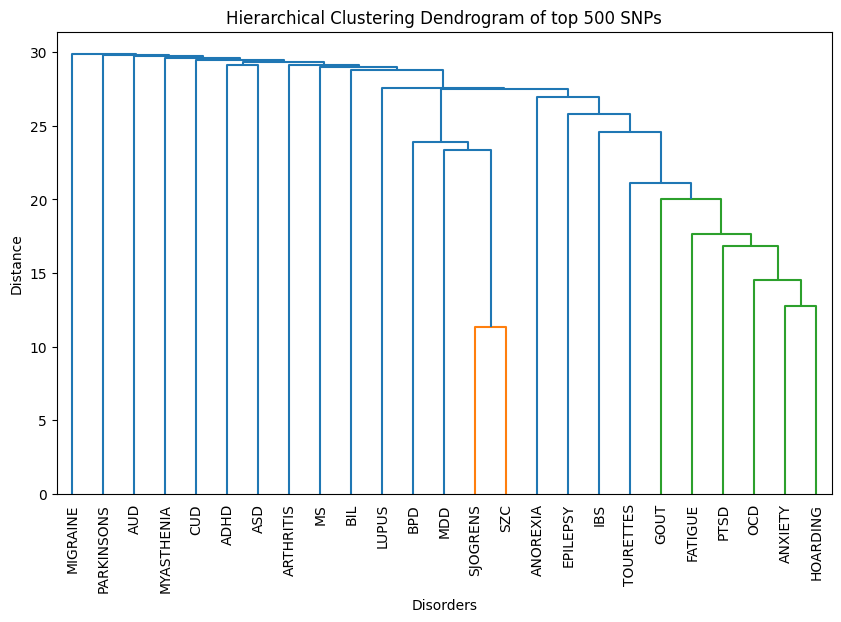

In [85]:
# Hierarchical clustering
linkage_matrix = hierarchy.linkage(top_snps_binary.T, method='average')


# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram = hierarchy.dendrogram(linkage_matrix, labels=all_snps_binary.columns)
plt.xlabel('Disorders')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram of top 500 SNPs')
plt.xticks(rotation=90)
plt.show() 

The number of SNPs shared between at least 2 disorders: 33


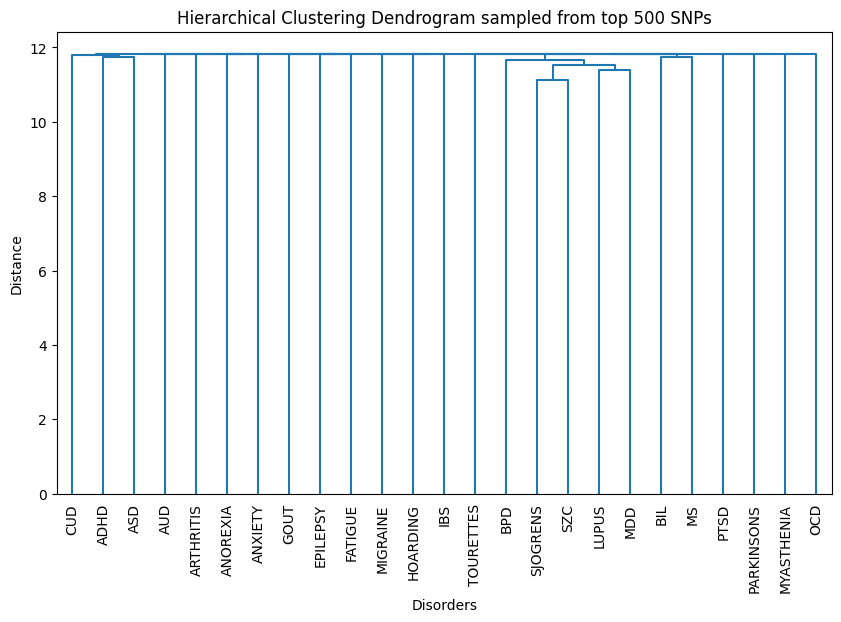

" # Compute the mean linkage matrix\nmean_linkage = np.mean(all_linkage, axis=0)\nprint(mean_linkage)\n# Plot the dendrogram for the mean linkage matrix\nplt.figure(figsize=(10, 6))\ndendrogram = hierarchy.dendrogram(mean_linkage)\nplt.xlabel('Disorders')\nplt.ylabel('Distance')\nplt.title('Consensus Hierarchical Clustering Dendrogram')\nplt.xticks(rotation=90)\nplt.show() "

In [86]:
#  randomly select a given number of SNPs
np.random.seed(42)
all_linkage = []

# Perform hierarchical clustering 10 times and store the linkage matrices
for _ in range(1):
    sampled_dfs = []
    for df in top_snp_list:
        sampled = df.sample(70, axis=0)
        sampled.reset_index(inplace=True, drop=True)
        sampled_dfs.append(sampled)

    sampled_binary = make_binary_snp_matrix(sampled_dfs)
    print('The number of SNPs shared between at least 2 disorders:', (sampled_binary.sum(axis=1) >= 2).sum())

    # Hierarchical clustering
    linkage_matrix = hierarchy.linkage(sampled_binary.T, method='average')
    all_linkage.append(linkage_matrix)

# Plot the dendrogram
    plt.figure(figsize=(10, 6))
    dendrogram = hierarchy.dendrogram(linkage_matrix, labels=sampled_binary.columns)
    plt.xlabel('Disorders')
    plt.ylabel('Distance')
    plt.title('Hierarchical Clustering Dendrogram sampled from top 500 SNPs')
    plt.xticks(rotation=90)
    plt.show()  

""" # Compute the mean linkage matrix
mean_linkage = np.mean(all_linkage, axis=0)
print(mean_linkage)
# Plot the dendrogram for the mean linkage matrix
plt.figure(figsize=(10, 6))
dendrogram = hierarchy.dendrogram(mean_linkage)
plt.xlabel('Disorders')
plt.ylabel('Distance')
plt.title('Consensus Hierarchical Clustering Dendrogram')
plt.xticks(rotation=90)
plt.show() """

In [313]:
#function to find the overlaps in SNPs and genes

def find_overlaps(binary_matrix, disorders_of_interest):
    overlaps = []
    overlapping_genes = set()

    for index, row in binary_matrix.iterrows():
        ones = {col for col, val in row.items() if val == 1 and col in disorders_of_interest}

        if ones and ones == set(disorders_of_interest):
            overlaps.append((index, ones))
            overlapping_genes.add(index)

    # Write overlapping genes to a file
    with open('genes_to_enrichR.txt', 'w') as file:
        for gene in overlapping_genes:
            file.write(gene + '\n')

    return overlaps, list(overlapping_genes) 


In [326]:
dis_of_int = ['SZC','BPD']
overlapping_genes, gene_list = find_overlaps(all_genes_binary, dis_of_int)
#overlapping_snps = find_overlaps(all_snps_binary)

In [327]:
overlapping_genes

[('AAGAB', {'BPD', 'SZC'}),
 ('ABCB4', {'BPD', 'SZC'}),
 ('ABCC10', {'BPD', 'SZC'}),
 ('ABHD14A', {'BPD', 'SZC'}),
 ('ABHD14B', {'BPD', 'SZC'}),
 ('ABHD15', {'BPD', 'SZC'}),
 ('ABT1', {'BPD', 'SZC'}),
 ('AC005609.1', {'BPD', 'SZC'}),
 ('AC006547.14', {'BPD', 'SZC'}),
 ('AC011997.1', {'BPD', 'SZC'}),
 ('AC074091.13', {'BPD', 'SZC'}),
 ('AC110781.3', {'BPD', 'SZC'}),
 ('AC137932.1', {'BPD', 'SZC'}),
 ('AC139100.2', {'BPD', 'SZC'}),
 ('ACHE', {'BPD', 'SZC'}),
 ('ACSBG1', {'BPD', 'SZC'}),
 ('ACSF2', {'BPD', 'SZC'}),
 ('ACSF3', {'BPD', 'SZC'}),
 ('ACTG2', {'BPD', 'SZC'}),
 ('ACTL6B', {'BPD', 'SZC'}),
 ('ACTR1A', {'BPD', 'SZC'}),
 ('ACTR1B', {'BPD', 'SZC'}),
 ('ACTR5', {'BPD', 'SZC'}),
 ('ACTR8', {'BPD', 'SZC'}),
 ('ACY1', {'BPD', 'SZC'}),
 ('ADAL', {'BPD', 'SZC'}),
 ('ADAM10', {'BPD', 'SZC'}),
 ('ADAM15', {'BPD', 'SZC'}),
 ('ADAMTS15', {'BPD', 'SZC'}),
 ('ADAMTS8', {'BPD', 'SZC'}),
 ('ADAMTSL3', {'BPD', 'SZC'}),
 ('ADAMTSL4', {'BPD', 'SZC'}),
 ('ADAMTSL4-AS1', {'BPD', 'SZC'}),
 ('ADAP2', {'

In [328]:
gene_list

['HIST1H4B',
 'DOC2A',
 'RHOD',
 'REG4',
 'RP11-343C2.9',
 'SETDB1',
 'NDUFA2',
 'NAA40',
 'ZNF165',
 'MYO18A',
 'PROB1',
 'HOPX',
 'SLX1B',
 'DNAH1',
 'ZSCAN2',
 'SGTA',
 'FIBP',
 'HDDC3',
 'ADAMTS8',
 'AC139100.2',
 'ZNF101',
 'UBN1',
 'TSSK6',
 'GAS8',
 'TRIM8',
 'B3GAT1',
 'RBKS',
 'WBP1L',
 'ACSBG1',
 'CR2',
 'ZFP90',
 'HIST1H4J',
 'CITED4',
 'HP',
 'GSTO2',
 'PNPLA7',
 'HSD3B7',
 'RP1L1',
 'FBXO11',
 'DFNA5',
 'PACS1',
 'HSPD1',
 'LRRC57',
 'SRPK2',
 'NR1D1',
 'KCNJ10',
 'PCDHB11',
 'CHTOP',
 'GIT2',
 'DHX35',
 'YJEFN3',
 'ETF1',
 'CNNM4',
 'HIST1H4L',
 'HAPLN4',
 'PLA2G16',
 'DNTTIP1',
 'ANAPC7',
 'RBX1',
 'TLR9',
 'PHF21A',
 'CD83',
 'CKMT1A',
 'DPH7',
 'EP300',
 'PARP3',
 'CSDC2',
 'PCDHAC1',
 'CCDC88B',
 'CYB5R3',
 'TAF7',
 'TMEM178B',
 'TMEM62',
 'ORAI3',
 'CERS6',
 'RPL29',
 'SLC7A6',
 'CRK',
 'SLC5A6',
 'HFE',
 'AP000721.4',
 'SV2A',
 'ZDHHC24',
 'DHX38',
 'PABPC1L',
 'KLHL3',
 'DHODH',
 'HIST1H2BF',
 'USMG5',
 'PCBP4',
 'GIT1',
 'ITFG2',
 'VWDE',
 'HIST1H4E',
 'SRRT',
 'B

In [94]:
shared_genes = pd.DataFrame(index=all_genes_binary.columns, columns=all_genes_binary.columns, dtype=int)

#Iterate through all pairs of disorders and count genes shared
for disorder1 in all_genes_binary.columns:
    for disorder2 in all_genes_binary.columns:
        count=sum(all_genes_binary[disorder1] & all_genes_binary[disorder2])
        shared_genes.at[disorder1,disorder2] = count

#Add total number of genes in each disorder on the diagonal
for disorder in all_genes_binary.columns:
    total_count = all_genes_binary[disorder].sum()
    shared_genes.at[disorder, disorder] = total_count

#get lower triangular matrix including the diagonal
#shared_lower = pd.DataFrame(np.tril(shared_genes), index=genes_binary.columns, columns=genes_binary.columns)
disorders = shared_genes.columns.tolist()
disorder_matrix = shared_genes.to_numpy()

In [ ]:
# Create a mask for the upper triangular part
mask = np.triu(np.ones_like(shared_genes), k=1).astype(bool)

# Set the values in the upper triangular part to NaN
shared_genes[mask] = np.nan

# Specify the size of the heatmap
fig, ax = plt.subplots(figsize=(15, 15))

# Plot the heatmap
sns.heatmap(shared_genes, annot=True, fmt='.0f', cmap='Greys', cbar=False)
plt.title('Shared genes')
plt.show()

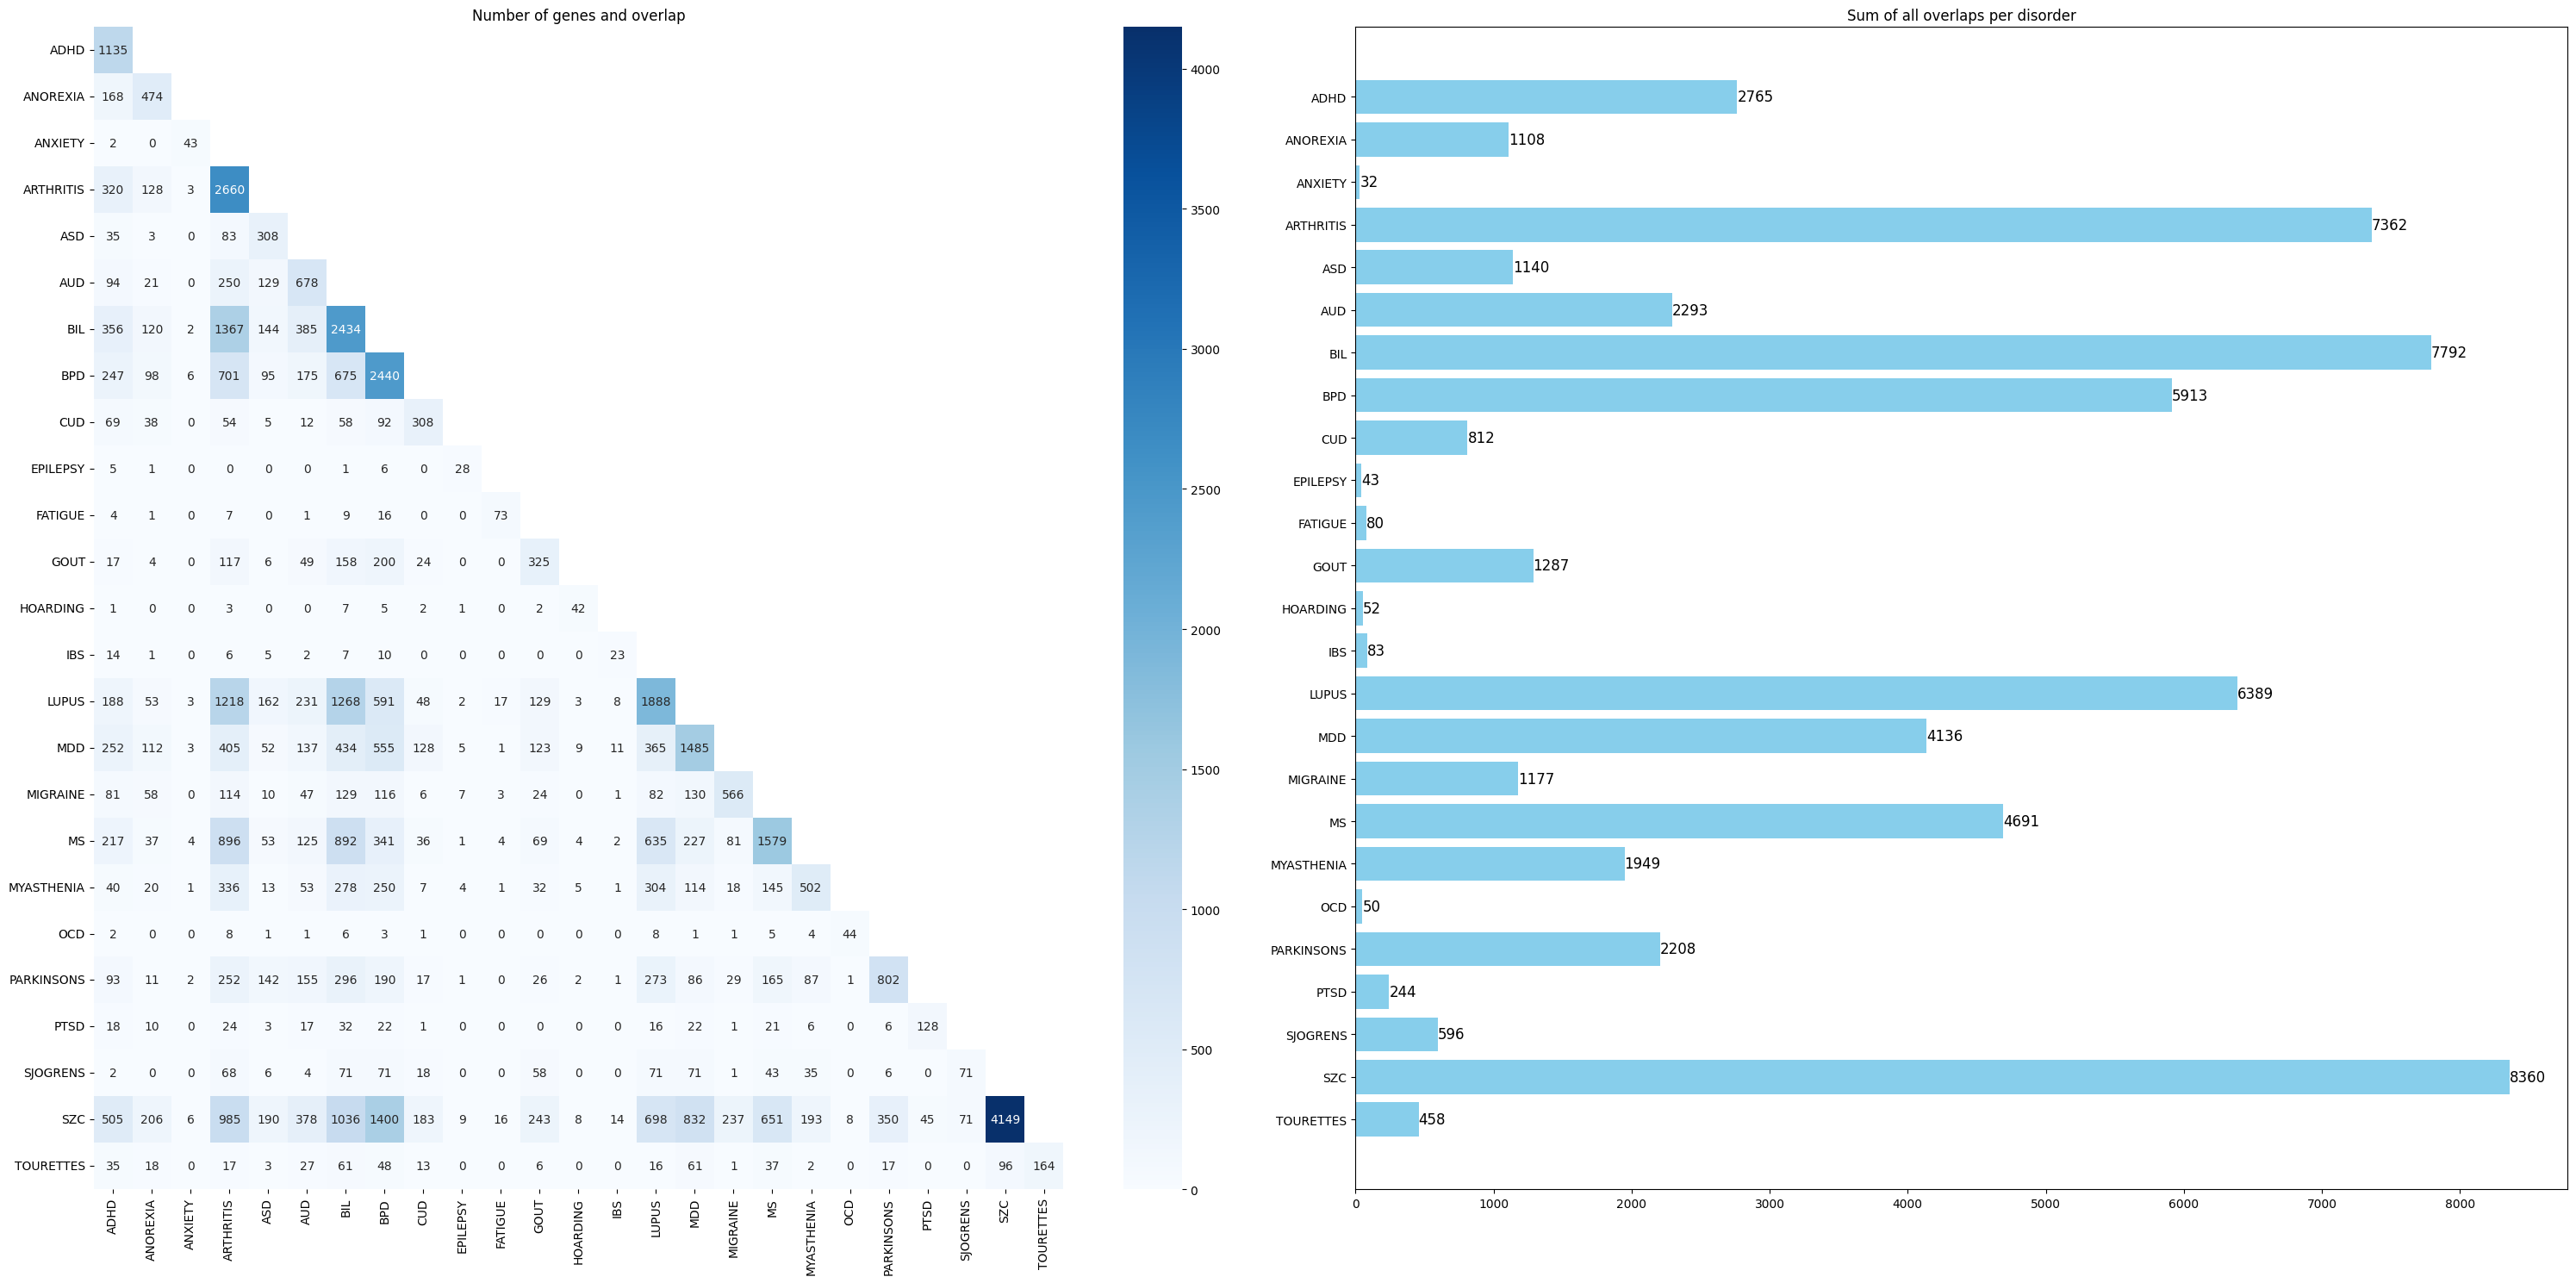

In [163]:
full_gene_matrix = np.tril(shared_genes) + np.tril(shared_genes, -1).T
full_gene_df = pd.DataFrame(full_gene_matrix, index=disorders, columns=disorders)

diagonal_mask = np.eye(len(full_gene_df), dtype=bool)
mask = np.triu(np.ones_like(full_gene_df, dtype=bool),k=1)
row_sums = (full_gene_df.mask(diagonal_mask)).sum(axis=1)

# Reverse the order of row sums and index labels
row_sums = row_sums[::-1]
index_labels = full_gene_df.index[::-1]

# Plot the heatmap and row sums together
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,15))

# Heatmap plot
sns.heatmap(full_gene_df, ax=ax1, cmap='Blues', annot=True, fmt='.0f',mask=mask)
ax1.set_title('Number of genes and overlap')

# Bar plot for row sums
bars = ax2.barh(index_labels, row_sums, color='skyblue')
ax2.set_title('Sum of all overlaps per disorder')

# Add labels to the bars
for bar, row_sum in zip(bars, row_sums):
    ax2.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{row_sum:.0f}', 
             va='center', ha='left', fontsize=12)

plt.tight_layout()
plt.show()

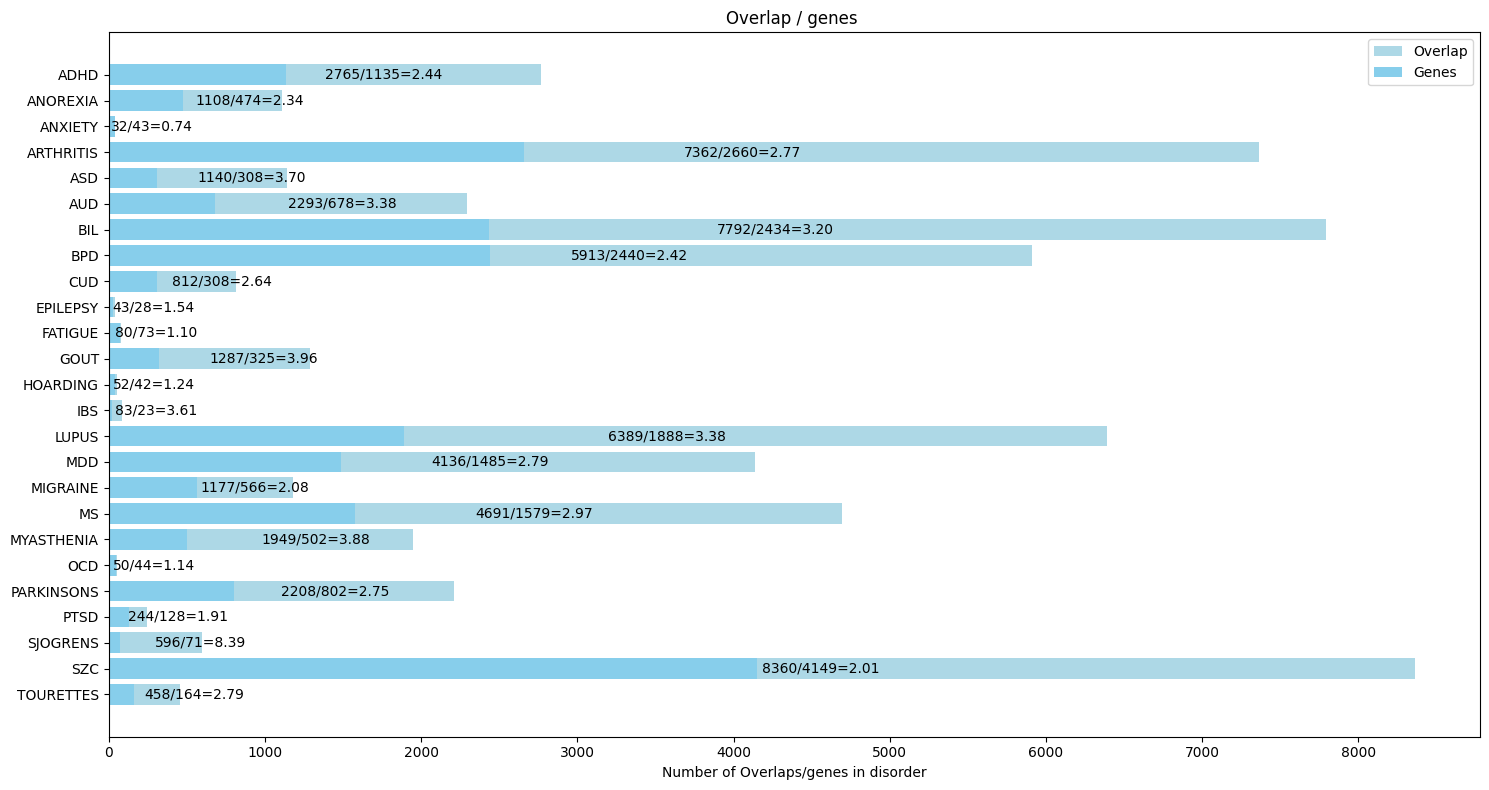

In [236]:
diagonal_mask_genes = np.eye(len(full_gene_df), dtype=bool)
mask_genes = np.triu(np.ones_like(full_gene_df, dtype=bool), k=1)

# Extract diagonal elements
diagonal_values_genes = np.diag(full_gene_df)[::-1]

# Calculate row sums, excluding the diagonal
row_sums_genes = (full_gene_df.mask(diagonal_mask_genes)).sum(axis=1)
row_sums_genes = row_sums_genes[::-1]

# Calculate fractions by dividing row sums by diagonal values
fractions_genes = row_sums_genes / diagonal_values_genes

# Reverse the order of row sums, index labels, and fractions

index_labels_genes = full_gene_df.index[::-1]


# Plot the heatmap and row sums together
fig, ax = plt.subplots(figsize=(15, 8))

# Plot bars for row sums
bars = ax.barh(index_labels_genes, row_sums_genes, color='lightblue', label='Overlap')

# Plot diagonal values with a different color shade
diagonal_bars_genes = ax.barh(index_labels_genes, diagonal_values_genes, color='skyblue', label='Genes')

# Add labels inside the bars
for bar, row_sum, diagonal_value, fraction in zip(bars, row_sums_genes, diagonal_values_genes, fractions_genes):
    label = f'{row_sum:.0f}/{diagonal_value:.0f}={fraction:.2f}'
    ax.text(bar.get_width() * 0.5, bar.get_y() + bar.get_height() * 0.5, label, 
             va='center', ha='left', color='black', fontsize=10)

# Add legend
ax.legend()

# Set title and labels
ax.set_title('Overlap / genes ')
ax.set_xlabel('Number of Overlaps/genes in disorder')

plt.tight_layout()
plt.show()

In [96]:
""" # function to randomly select a given number of SNPs
def select_snps_randomly(df_list, number_of_snps):
        sampled_dfs = []
        for df in df_list:
            sampled = df.sample(n=number_of_snps, replace=True)
    
            sampled_df = sampled[['rsID', 'disorder']]
            sampled_df.reset_index(inplace=True, drop=True)
            # reset index
            #sampled_df.reset_index()
            sampled_dfs.append(sampled_df)
            
        return sampled_dfs """

In [97]:
""" #function to make binary matrix with randobly selected snps
def make_random_binary_matrix(number_i, list_of_snps, number_of_snps):
    random_binary_list = []
    for i in range(number_i):
        random = select_snps_randomly(list_of_snps, number_of_snps)
        concatenated_random = pd.concat(random)
    
        binary = concatenated_random.pivot_table(index='rsID', columns='disorder', aggfunc=lambda x: 1, fill_value=0)
        random_binary_list.append(binary)
    return random_binary_list """


In [108]:
finngen = pd.read_csv('FinnGen/FinnGen_table_all_diseases.csv', sep=';', index_col=0)

In [ ]:
disorder_list = finngen.index.values.tolist()
fin_matrix = finngen.to_numpy()

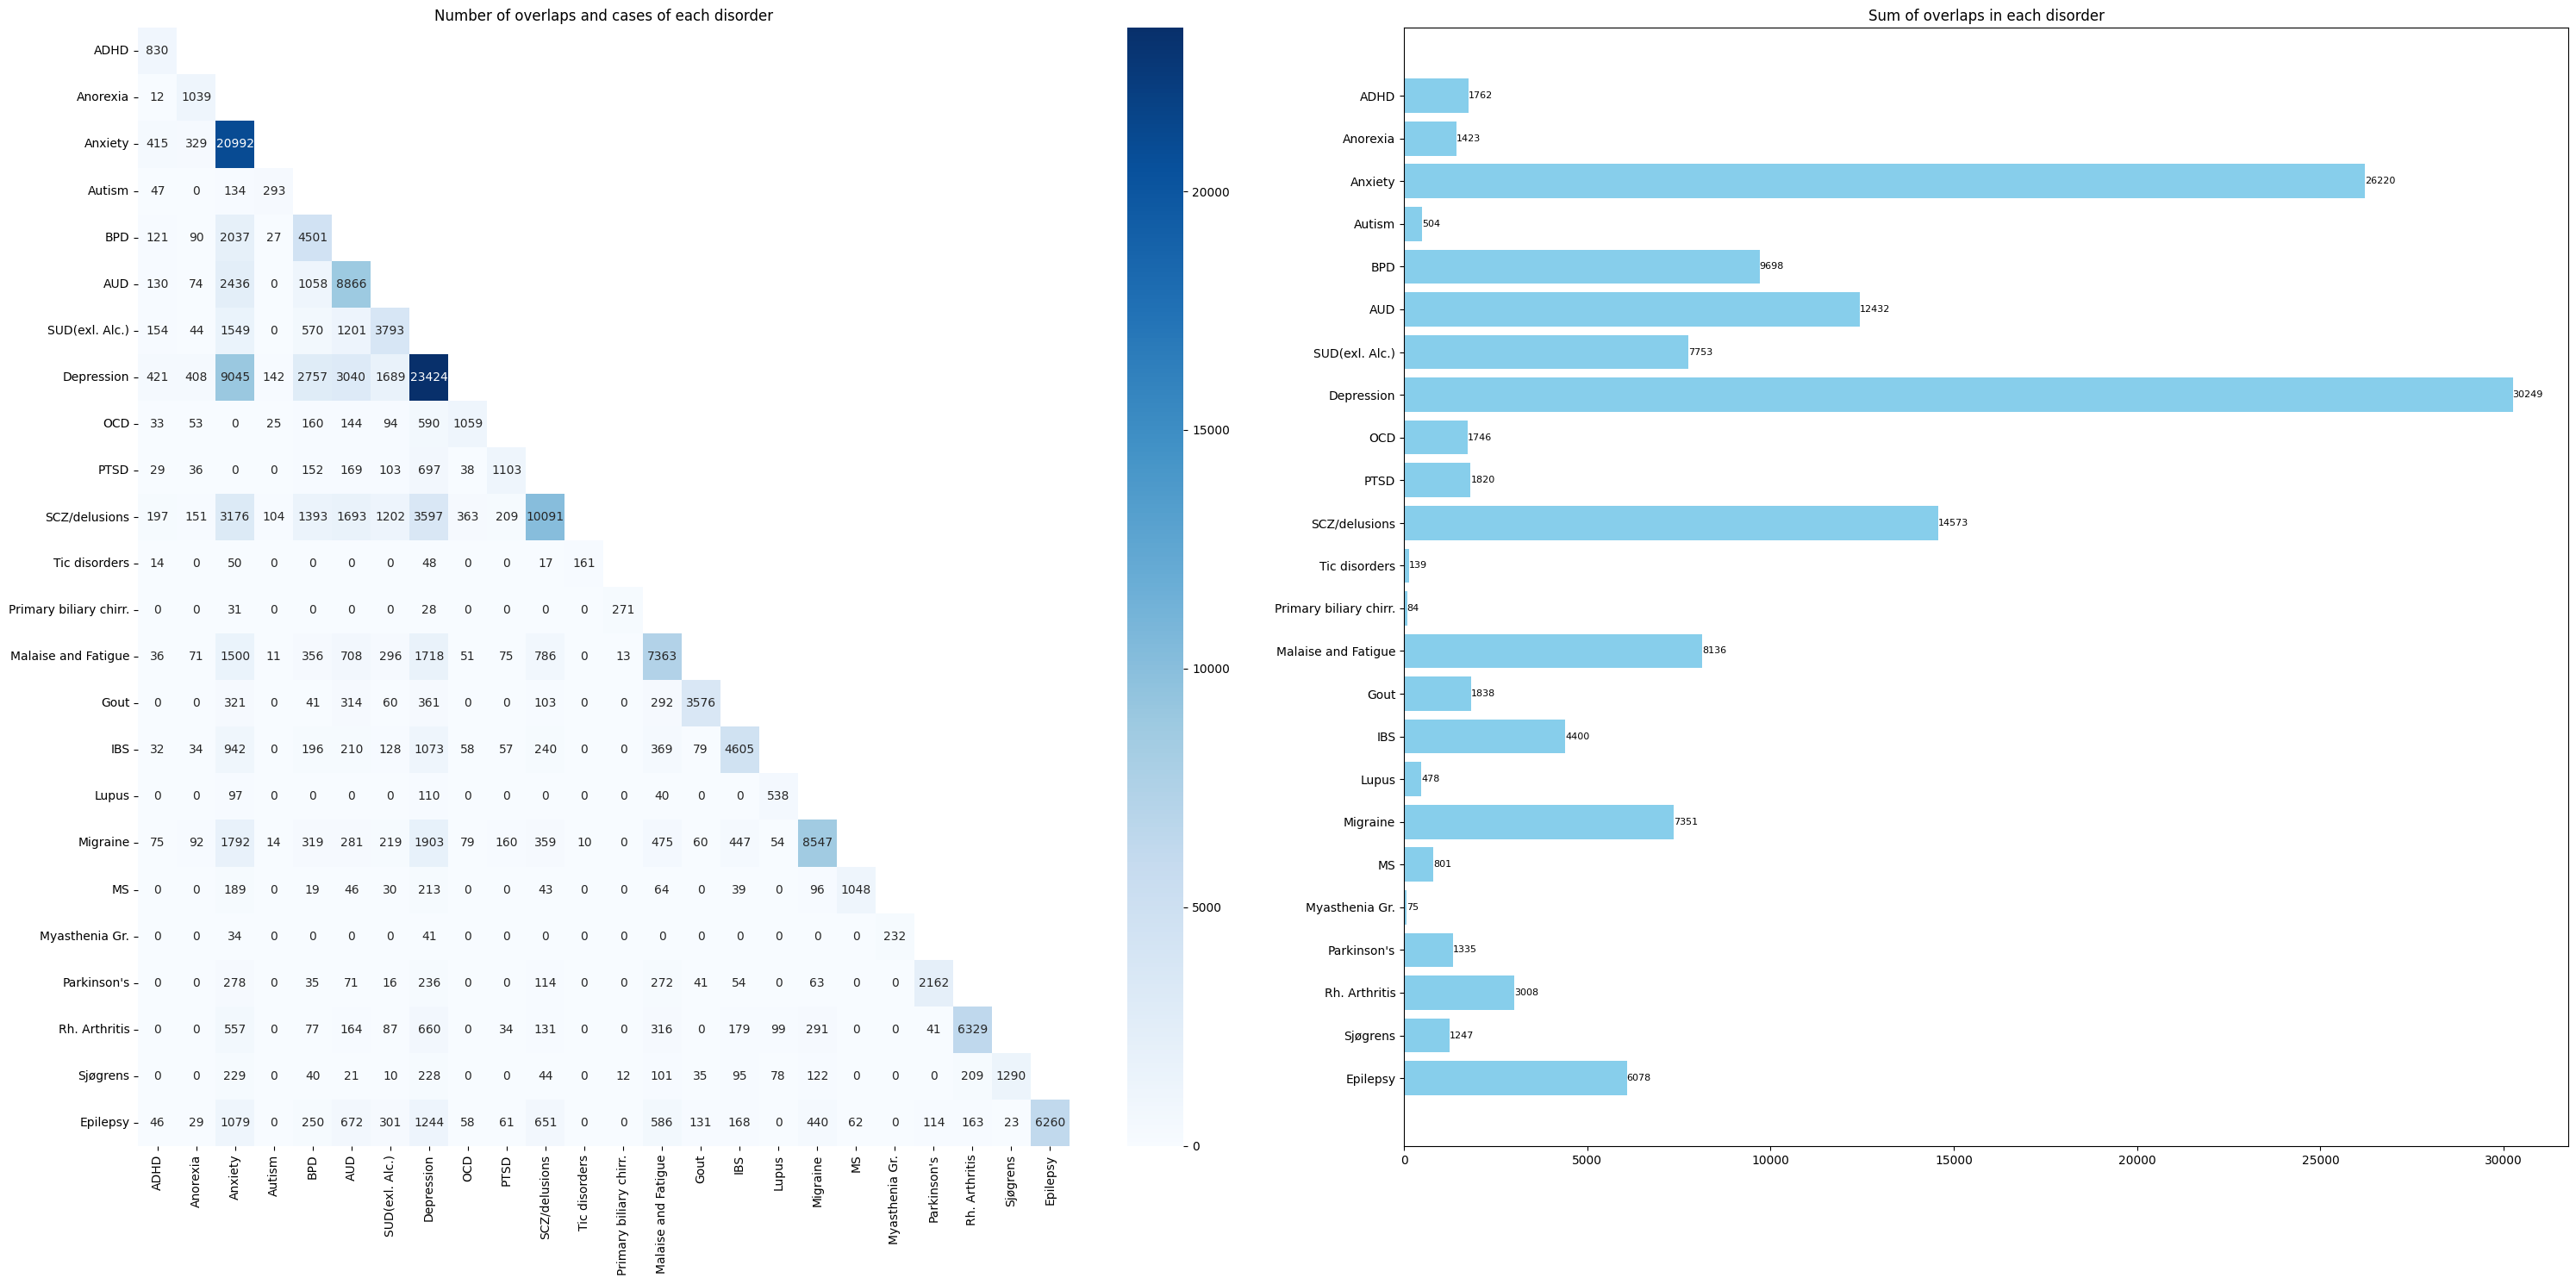

In [194]:
full_finngen_matrix2 = np.tril(finngen) + np.tril(finngen, -1).T
finngen2 = pd.DataFrame(full_finngen_matrix2, index=disorder_list, columns=disorder_list)

# Create a mask for the diagonal
diagonal_mask = np.eye(len(finngen2), dtype=bool)
mask = np.triu(np.ones_like(finngen2, dtype=bool), k=1)

# Calculate row sums, excluding the diagonal
row_sums = (finngen2.mask(diagonal_mask)).sum(axis=1)

# Reverse the order of row sums and index labels
row_sums = row_sums[::-1]
index_labels = finngen2.index[::-1]

# Plot the heatmap and row sums together
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,15))

# Heatmap plot
sns.heatmap(finngen2, ax=ax1, cmap='Blues', annot=True, fmt='.0f', mask=mask)
ax1.set_title('Number of overlaps and cases of each disorder')

# Bar plot for row sums
bars = ax2.barh(index_labels, row_sums, color='skyblue')
ax2.set_title('Sum of overlaps in each disorder')

# Add labels to the bars
for bar, row_sum in zip(bars, row_sums):
    ax2.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{row_sum:.0f}', 
             va='center', ha='left', fontsize=8)

plt.tight_layout()
plt.show()

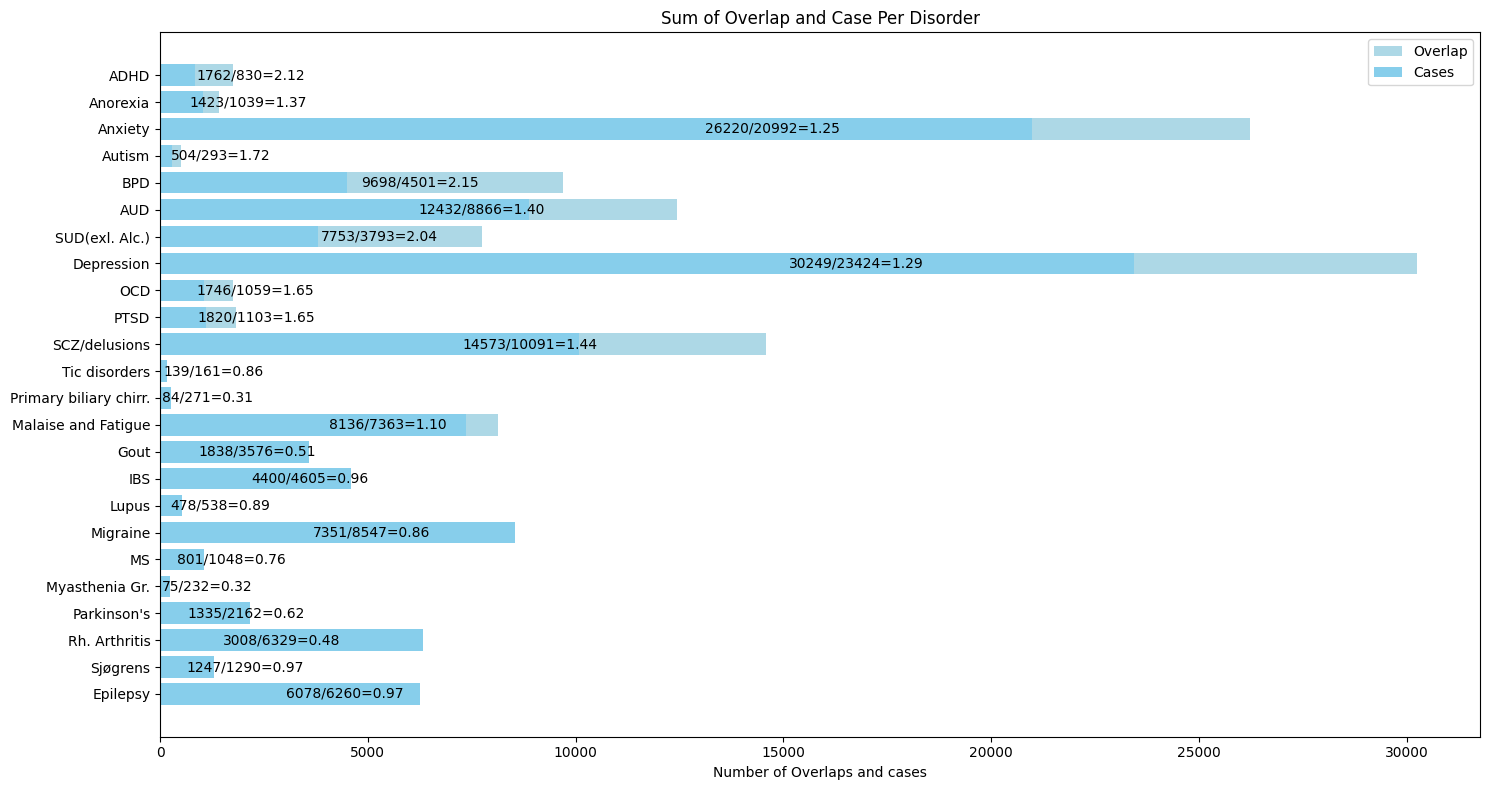

In [237]:
diagonal_mask = np.eye(len(finngen2), dtype=bool)
mask = np.triu(np.ones_like(finngen2, dtype=bool), k=1)

# Extract diagonal elements
diagonal_values = np.diag(finngen2)[::-1]

# Calculate row sums, excluding the diagonal
row_sums = (finngen2.mask(diagonal_mask)).sum(axis=1)
row_sums = row_sums[::-1]
# Calculate fractions by dividing row sums by diagonal values
fractions = row_sums / diagonal_values

# Reverse the order of row sums, index labels, and fractions

index_labels = finngen2.index[::-1]
#fractions = fractions[::-1]

# Plot the heatmap and row sums together
fig, ax = plt.subplots(figsize=(15, 8))

# Plot bars for row sums
bars = ax.barh(index_labels, row_sums, color='lightblue', label='Overlap')

# Plot diagonal values with a different color shade
diagonal_bars = ax.barh(index_labels, diagonal_values, color='skyblue', label='Cases')

# Add labels inside the bars
for bar, row_sum, diagonal_value, fraction in zip(bars, row_sums, diagonal_values, fractions):
    label = f'{row_sum:.0f}/{diagonal_value:.0f}={fraction:.2f}'
    ax.text(bar.get_width() * 0.5, bar.get_y() + bar.get_height() * 0.5, label, 
             va='center', ha='left', color='black', fontsize=10)

# Add legend
ax.legend()

# Set title and labels
ax.set_title('Sum of Overlap and Case Per Disorder')
ax.set_xlabel('Number of Overlaps and cases')

plt.tight_layout()
plt.show()

In [113]:

def hypergeometric_prob(matrix, disorder_list, M):

    matrix_shape= matrix.shape
    prob_matrix = np.zeros(matrix_shape)

    for i in range(1, matrix_shape[0]):
        for j in range(i):
            x =matrix[i,j]
            n = matrix[j,j]
            N = matrix[i, i]
            #print(M,n,x)
            
            prob = hypergeom.sf(x-1, M, n, N)
            
                
            prob_matrix[i,j] = prob

    return pd.DataFrame(prob_matrix, columns=disorder_list, index=disorder_list)

   

In [115]:
genes_prob_list = []
finngen_p = hypergeometric_prob(fin_matrix,disorder_list, 500000)
prob_genes_10K=hypergeometric_prob(disorder_matrix, disorders, 10000)
prob_genes_15K=hypergeometric_prob(disorder_matrix, disorders, 15000)
prob_genes_20K=hypergeometric_prob(disorder_matrix, disorders, 20000)
genes_prob_list.append(prob_genes_10K)
genes_prob_list.append(prob_genes_15K)
genes_prob_list.append(prob_genes_20K)

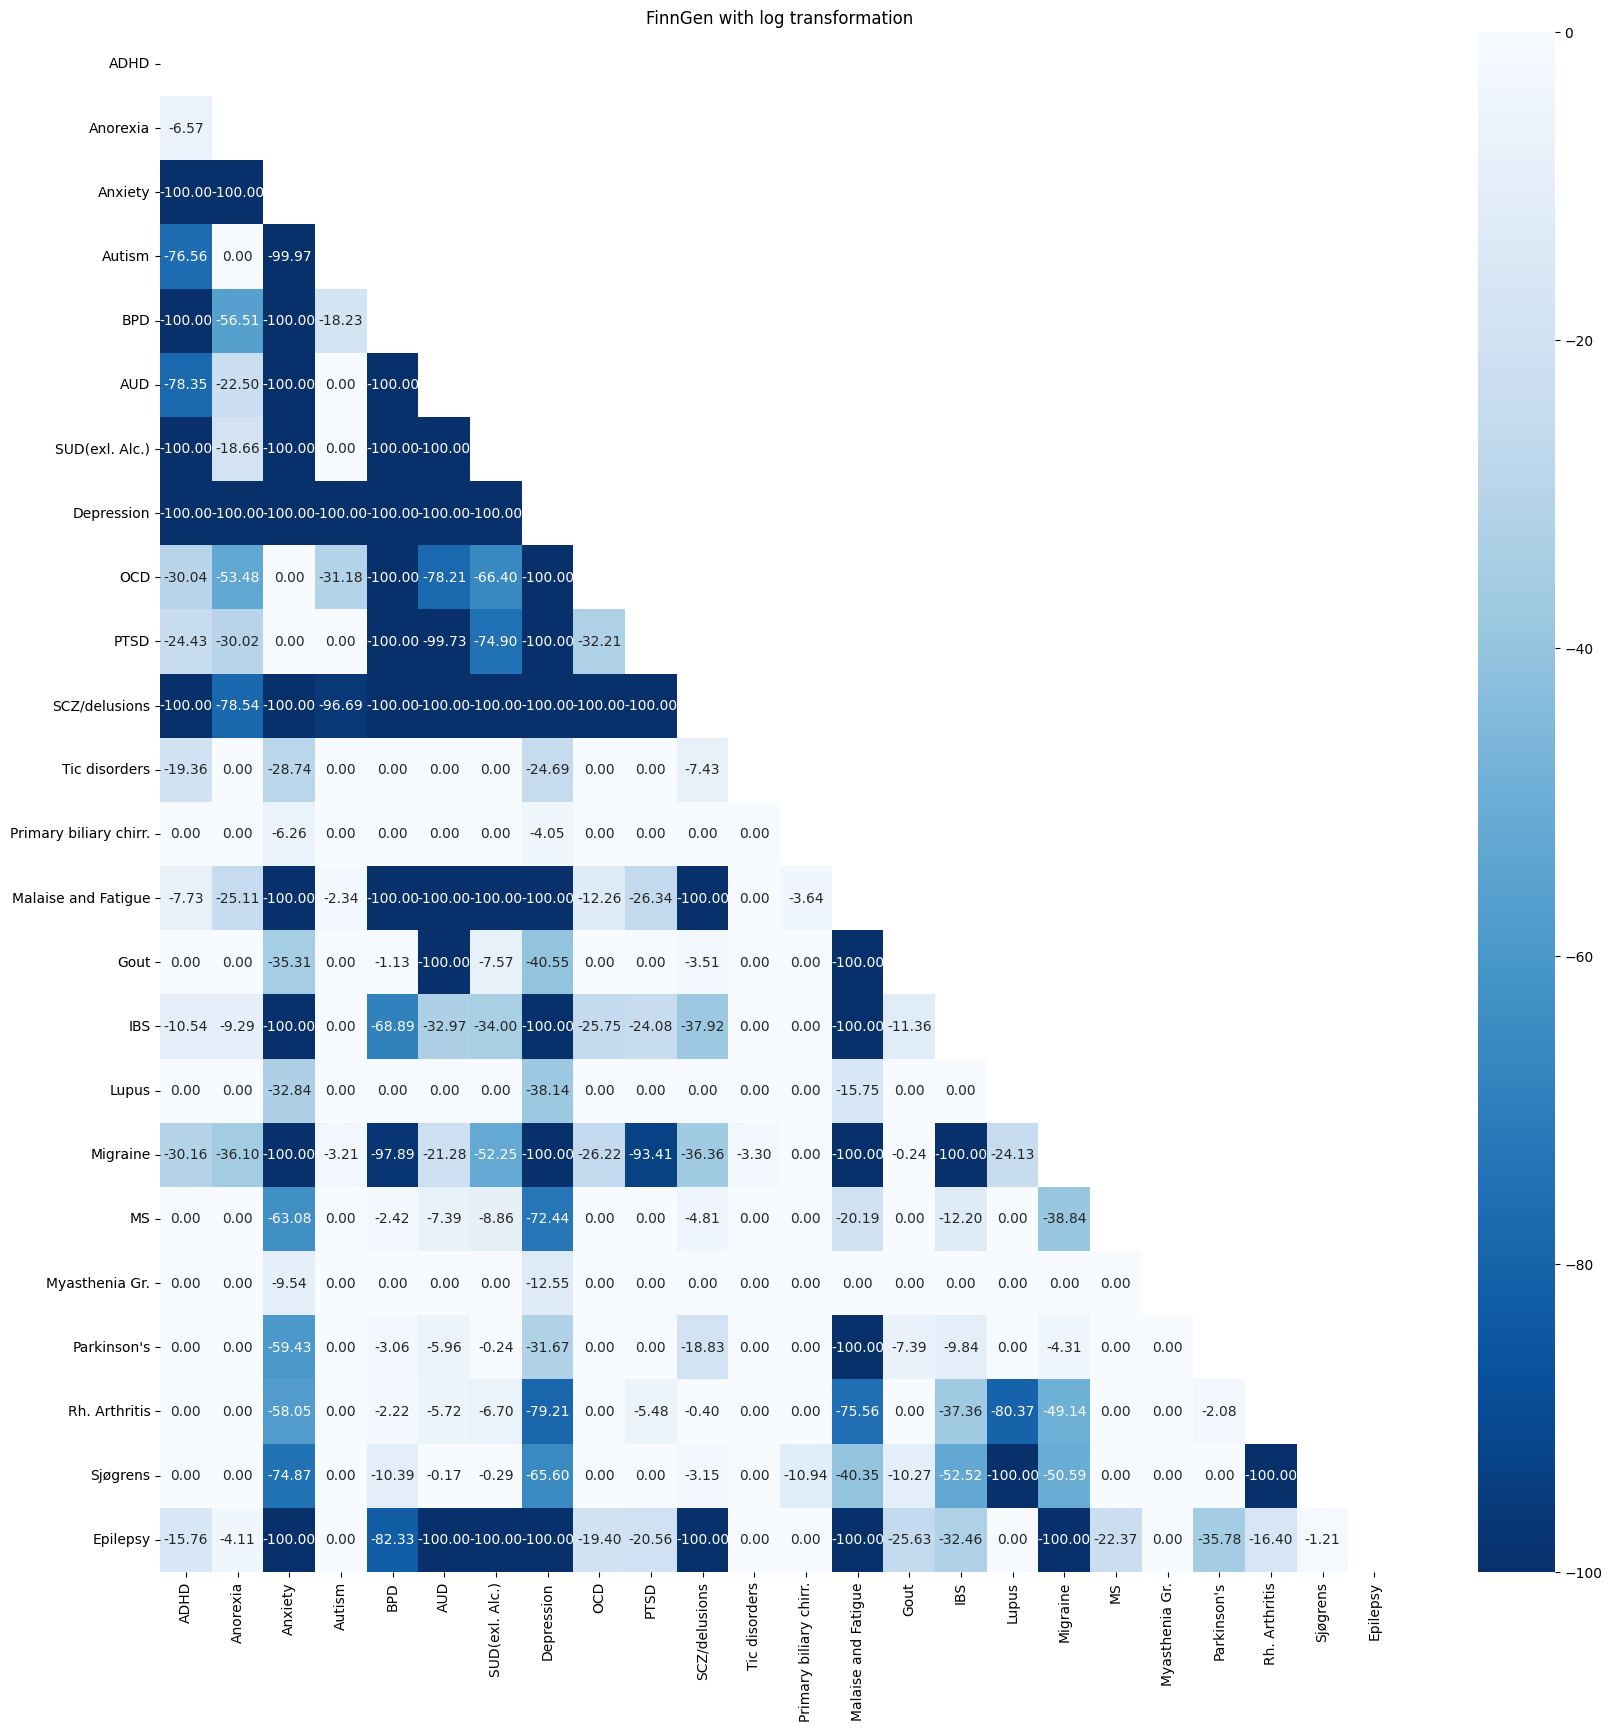

<Figure size 2000x1500 with 0 Axes>

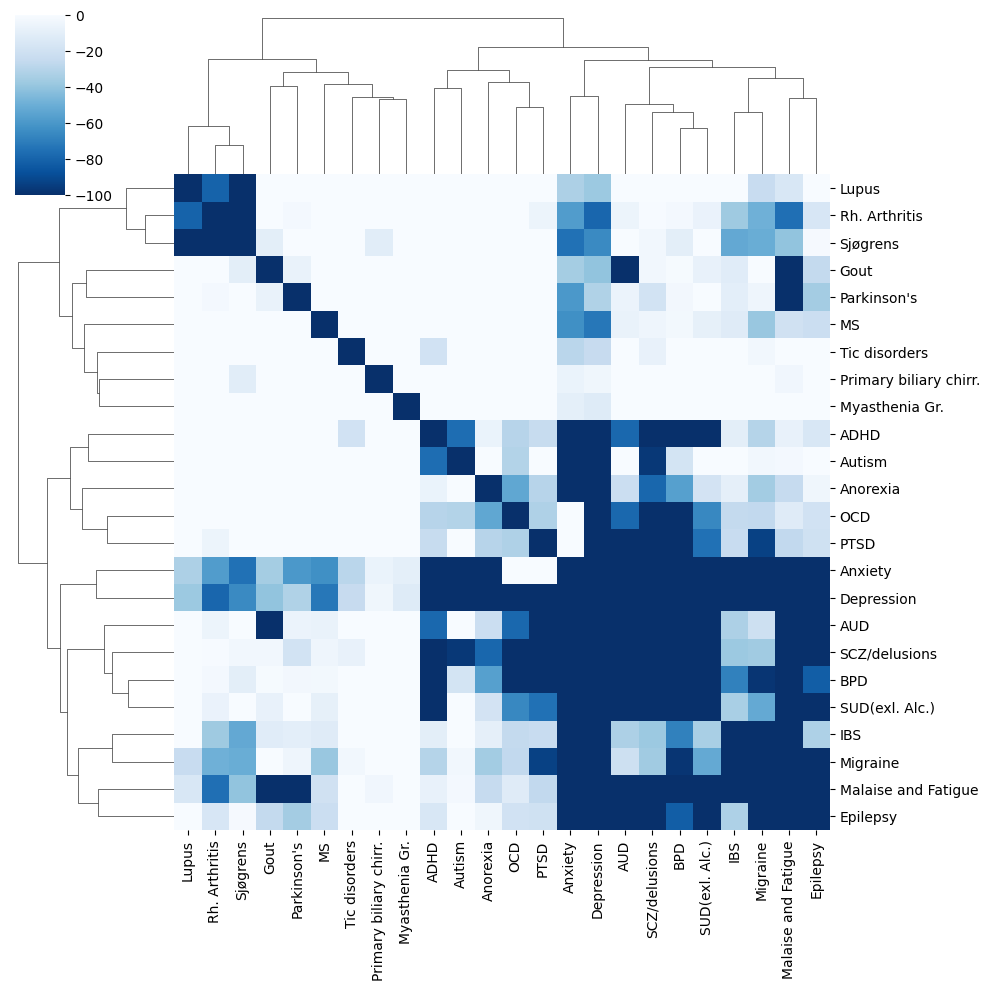

In [165]:

# Create a mask for the upper triangular part
mask = np.triu(np.ones_like(finngen_p, dtype=bool))

# Set the upper triangular part to NaN to exclude it from the plot
finngen_p = finngen_p.mask(mask)

#Apply log transformation
finngen_log = np.log10(finngen_p+1e-100)

#reverse colormap
cmap = 'Blues'
cmap_reversed = cmap + '_r'

fig, ax = plt.subplots(figsize=(20,20))
plt.title('FinnGen with log transformation')
sns.heatmap(finngen_log, annot=True,fmt='.2f',cmap=cmap_reversed, cbar=True)

full_finngen_matrix = np.tril(finngen_p) + np.tril(finngen_p, -1).T
full_finngen_df = pd.DataFrame(full_finngen_matrix, index=disorder_list, columns=disorder_list)
full_finngen_df = full_finngen_df.fillna(1e-100)
full_finngen_log = np.log10(full_finngen_df+1e-100)
plt.figure(figsize=(20,15))
sns.clustermap(full_finngen_log,cmap=cmap_reversed)
plt.show()


In [238]:
from matplotlib_venn import venn2,venn3
def venn_diagrams(df, Column1, Column2):
    unique_values_col1 = set(df[Column1])
    unique_values_col2 = set(df[Column2])



    # Create the Venn diagram
    venn2(subsets=(unique_values_col1, unique_values_col2), set_labels=(Column1, Column2))

    # Add title
    plt.title('Venn Diagram')

    # Show the plot
    plt.show()

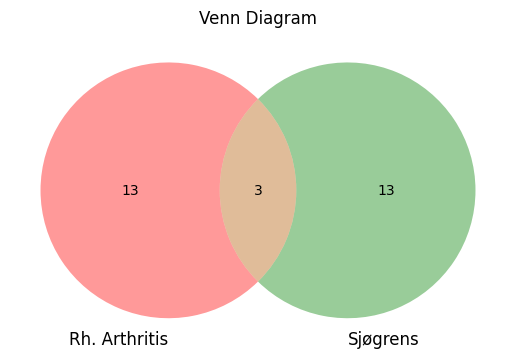

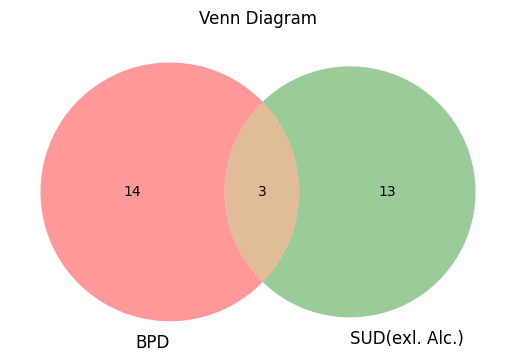

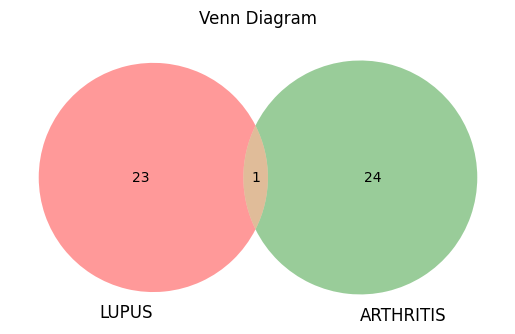

In [241]:
venn_finngen = venn_diagrams(full_finngen_df, 'Rh. Arthritis', 'Sjøgrens')
venn_finngen2 = venn_diagrams(full_finngen_df, 'BPD', 'SUD(exl. Alc.)')
venn_genes = venn_diagrams(shared_genes, 'LUPUS', 'ARTHRITIS')

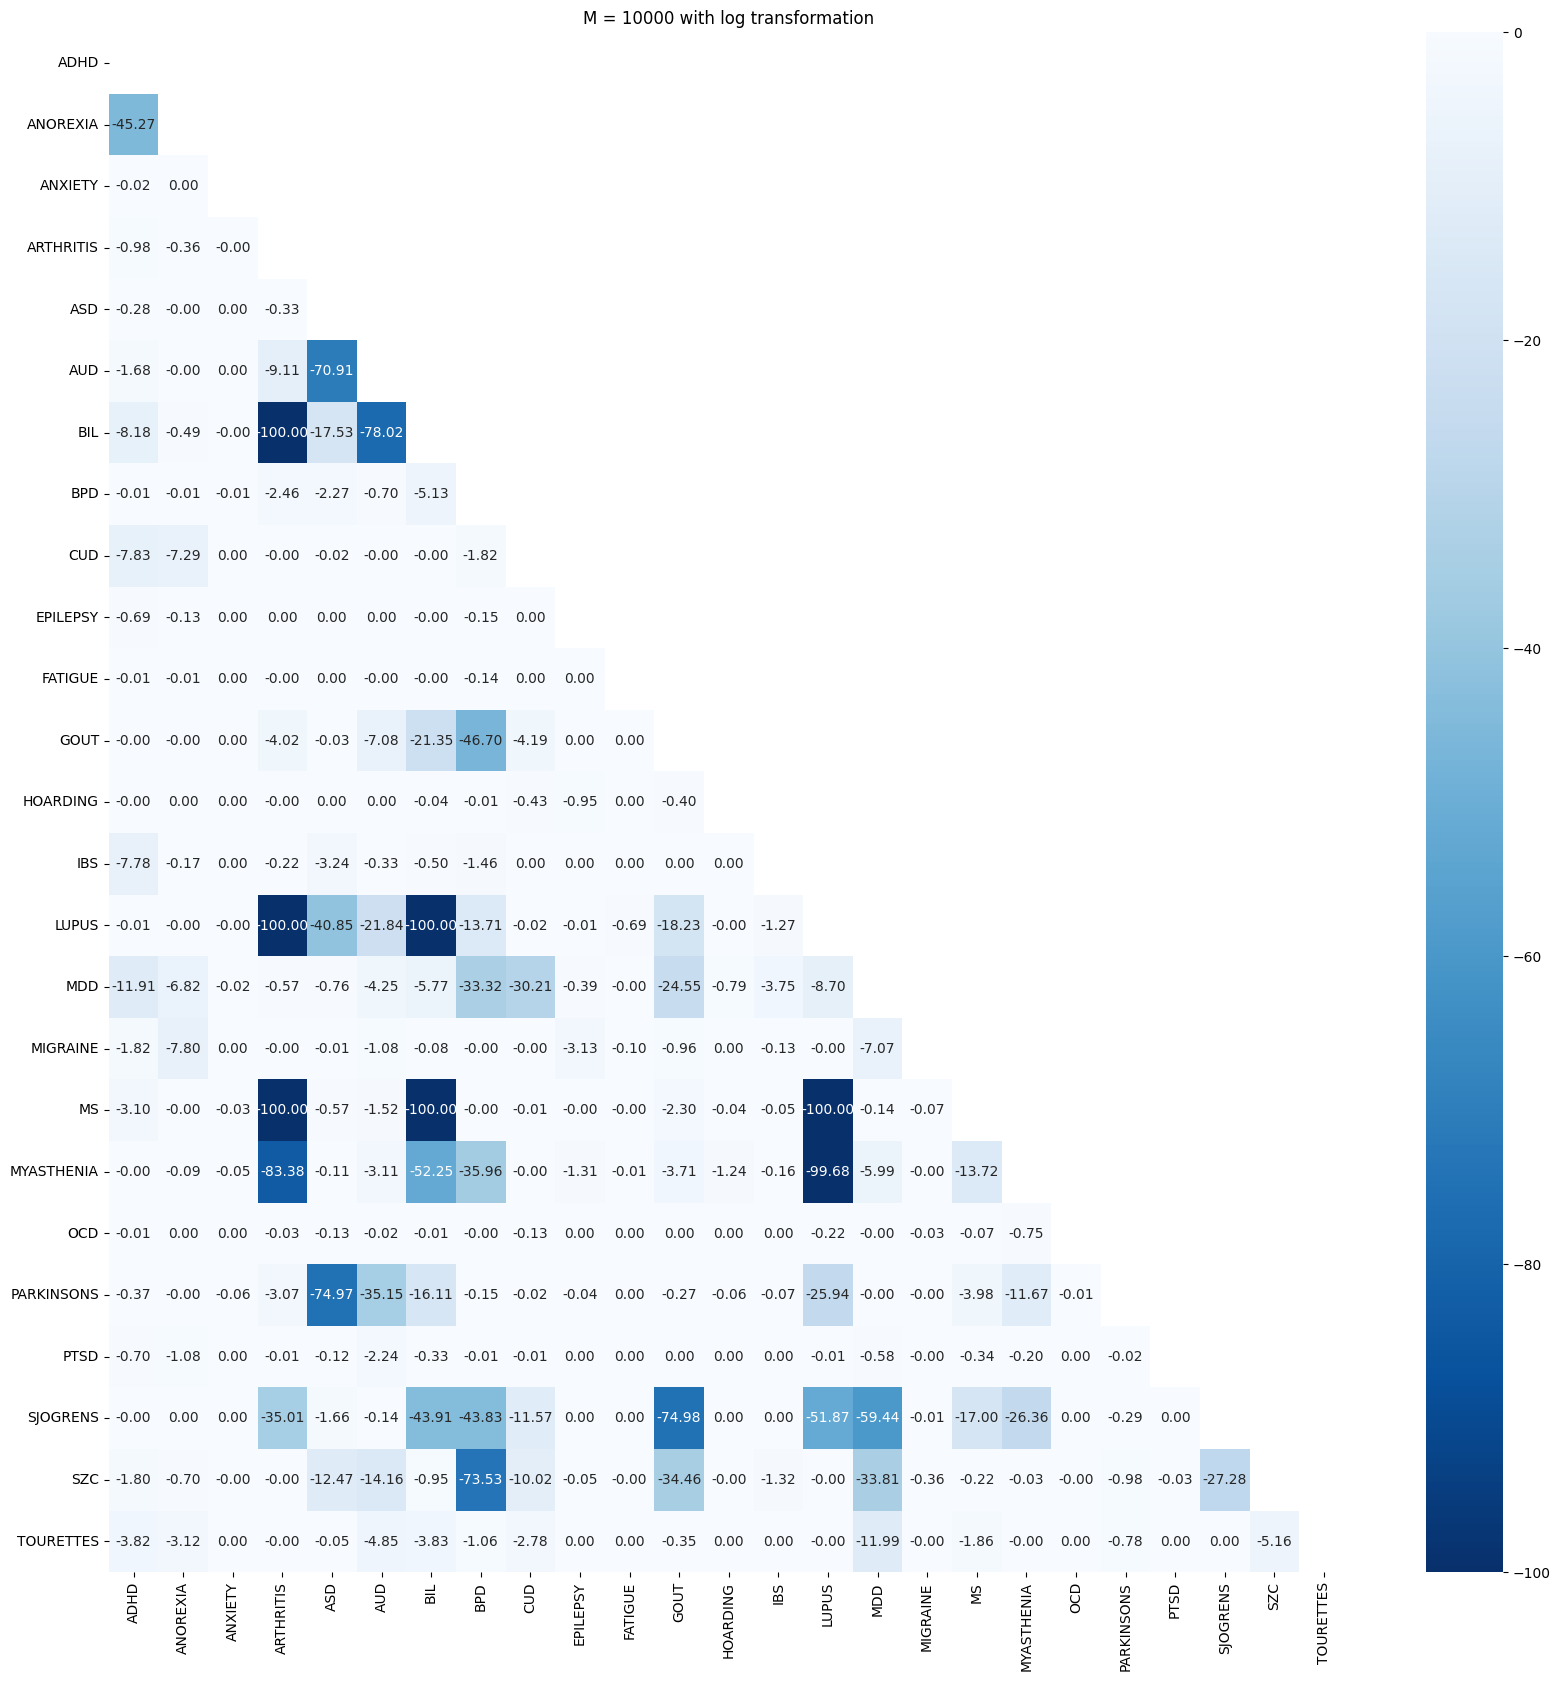

<Figure size 2000x1500 with 0 Axes>

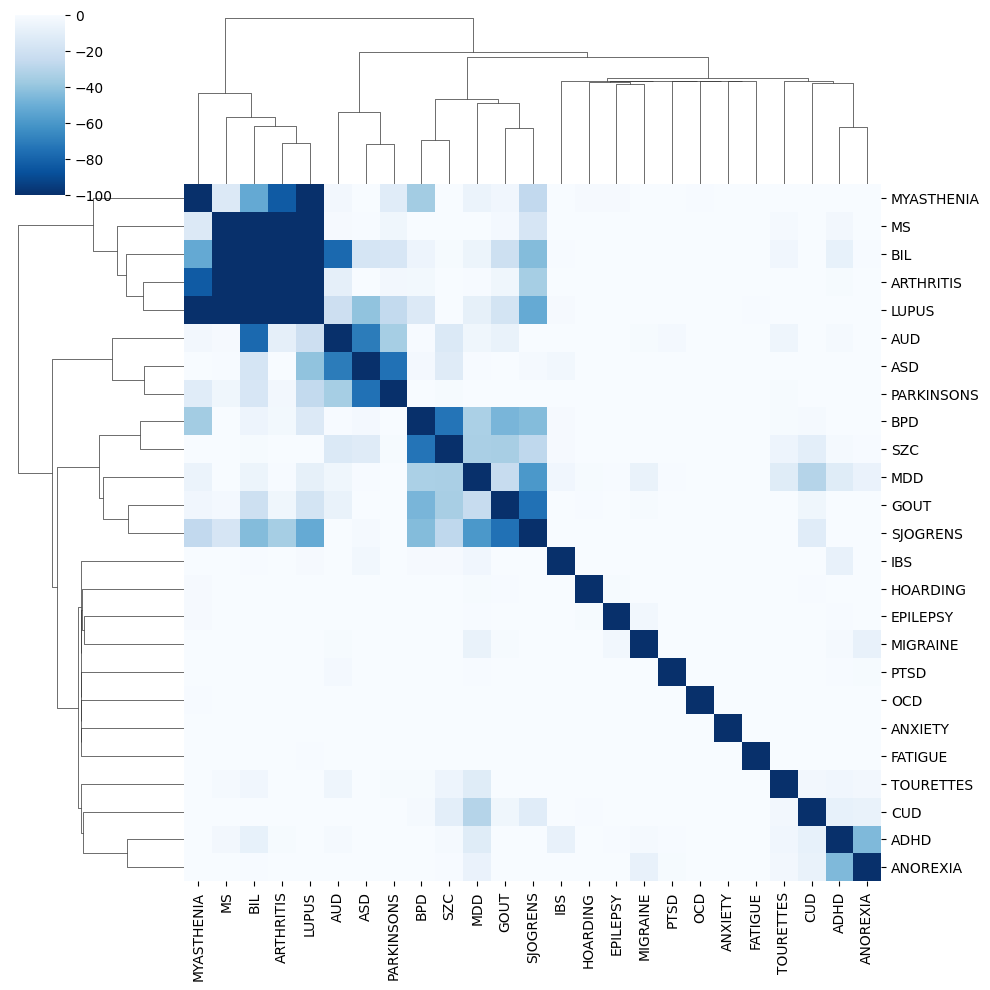

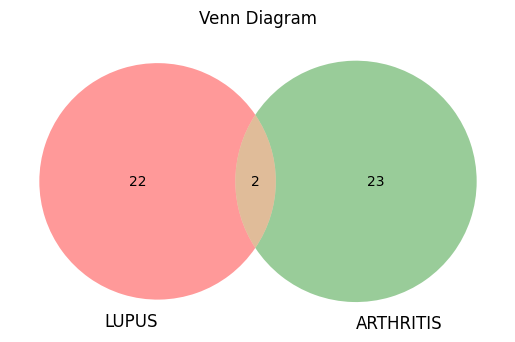

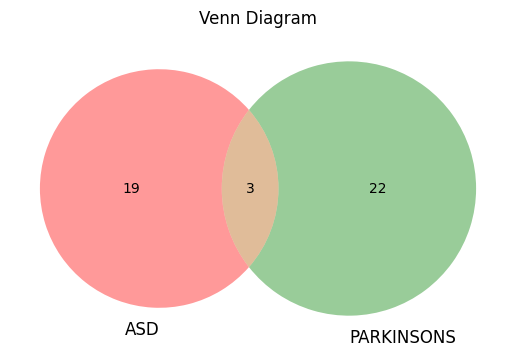

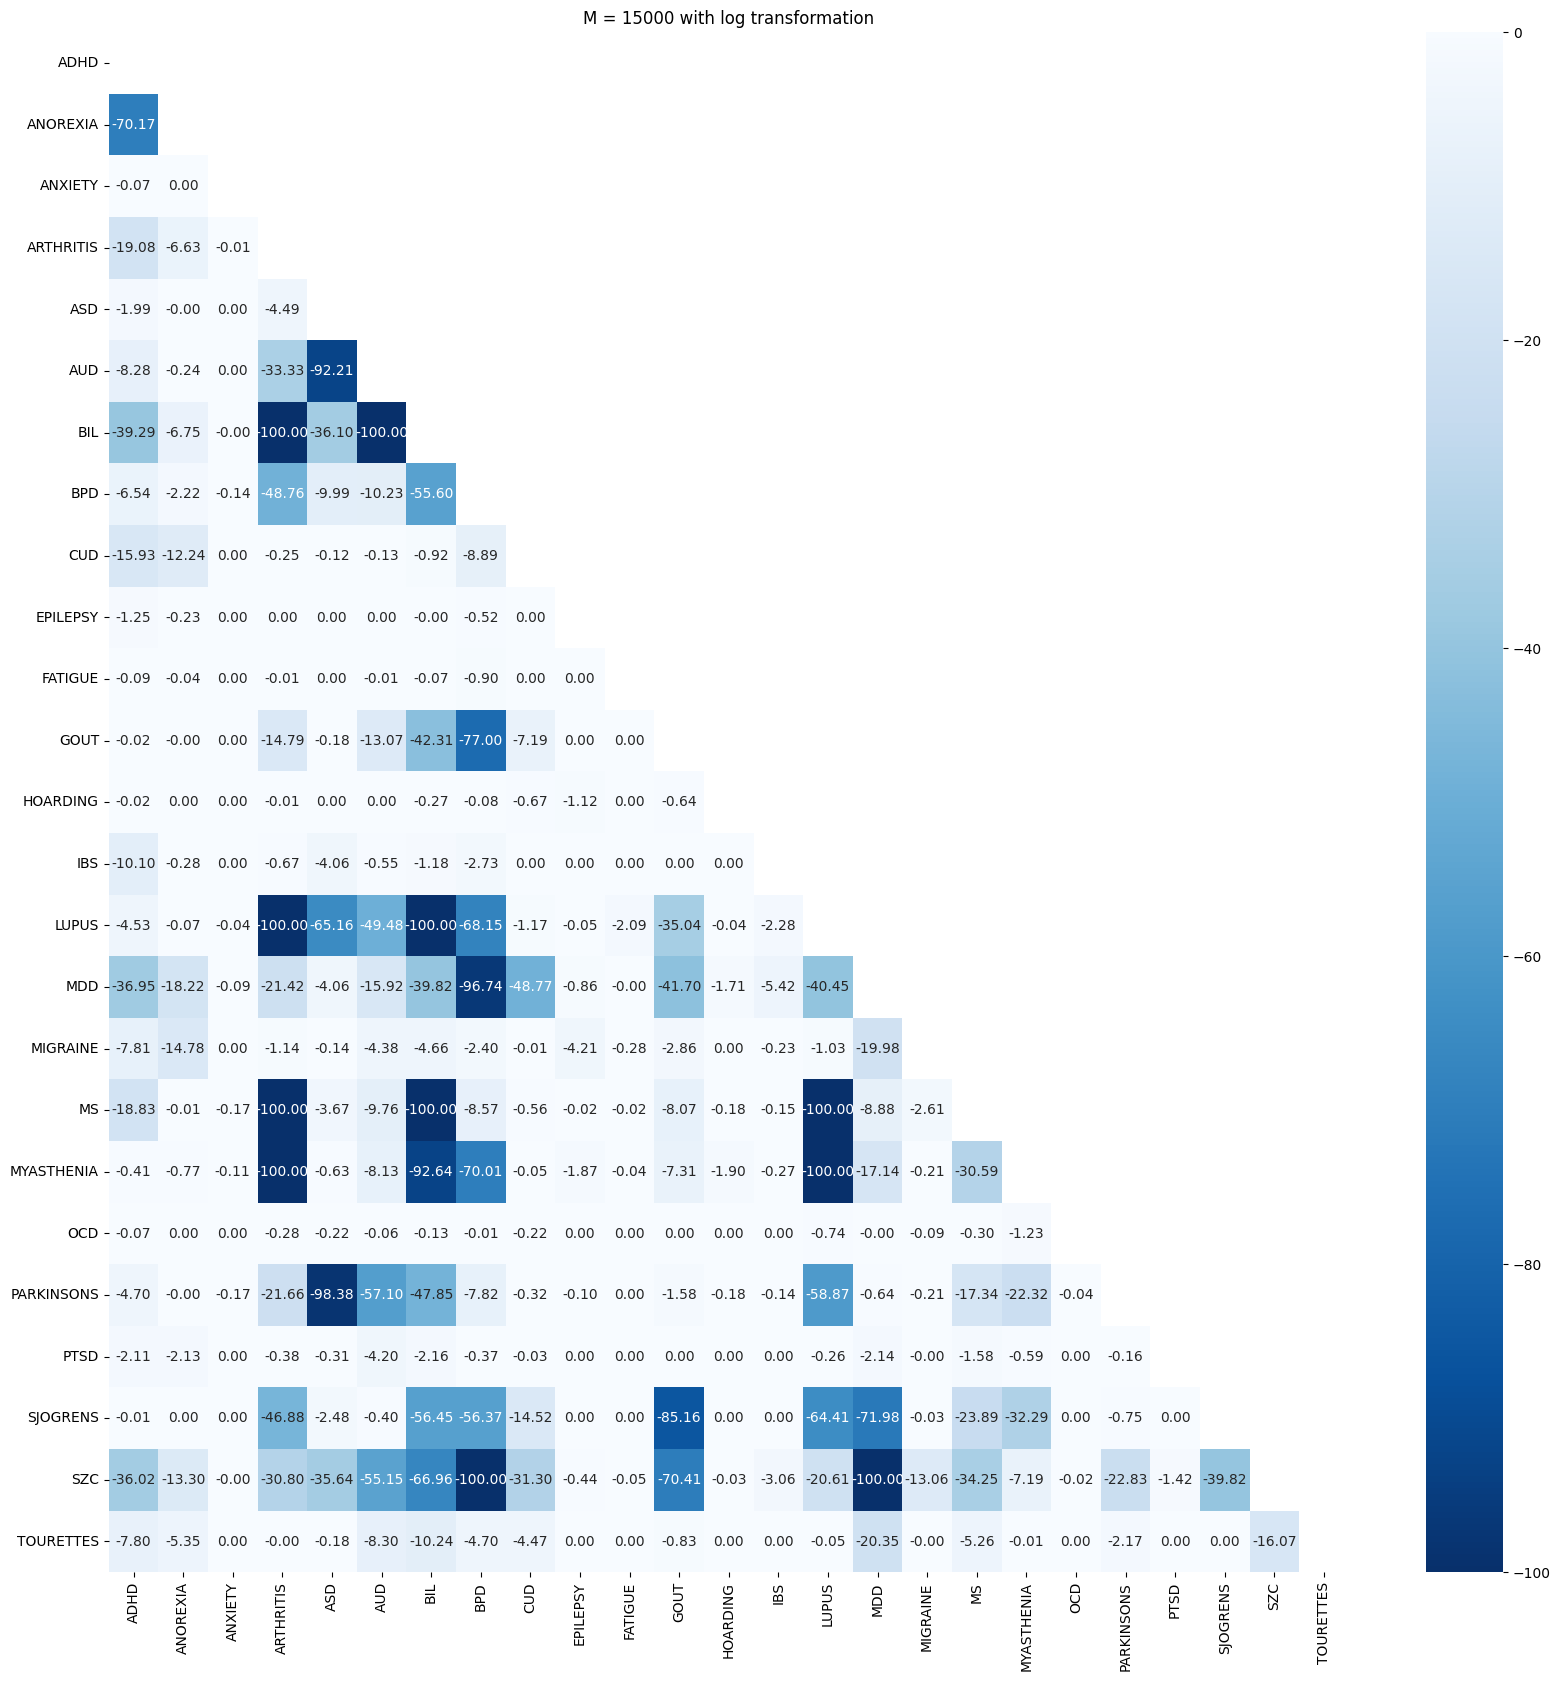

<Figure size 2000x1500 with 0 Axes>

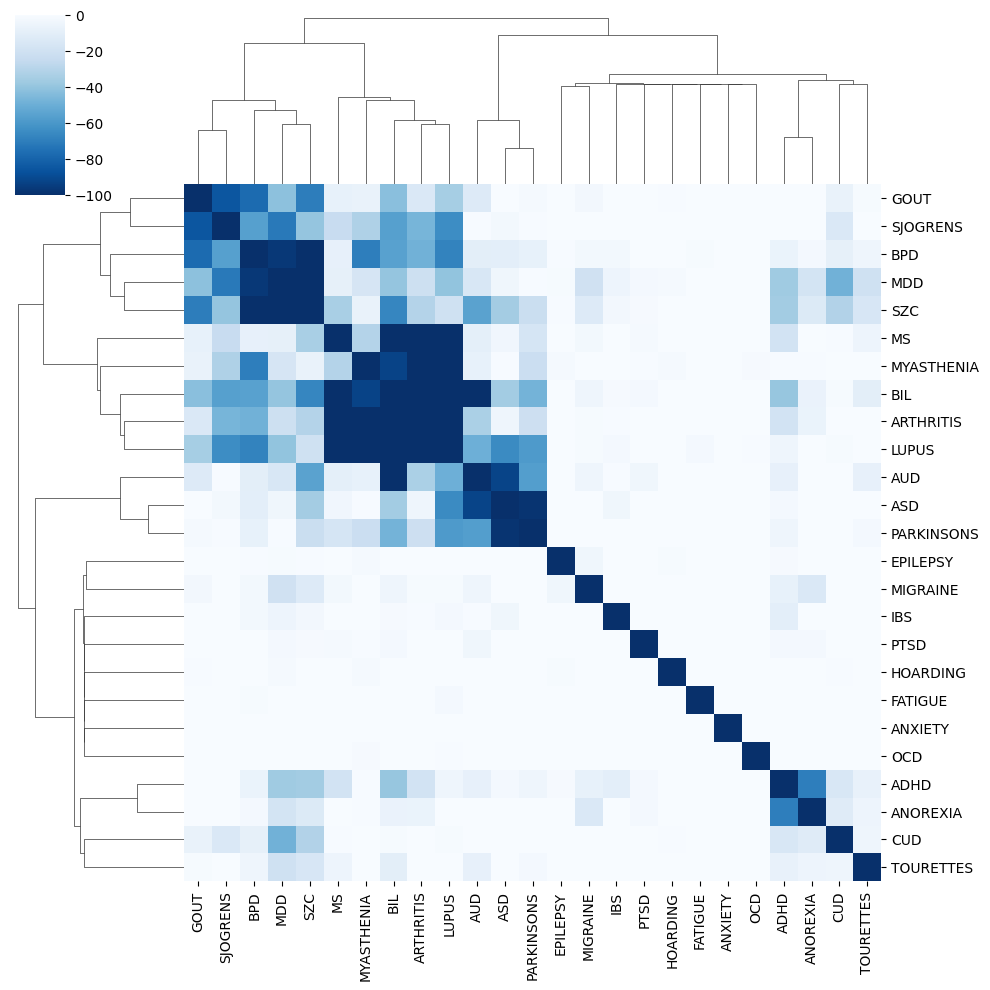

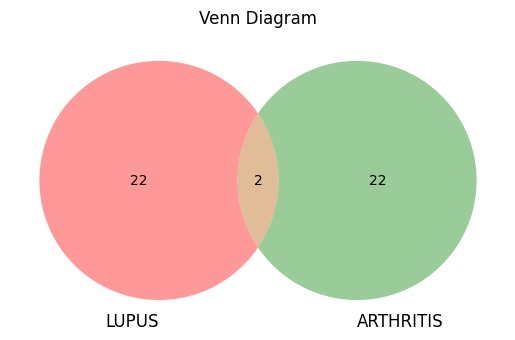

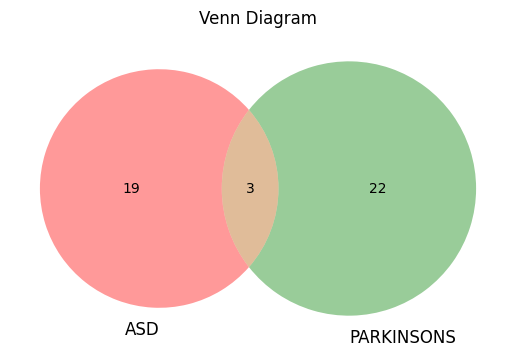

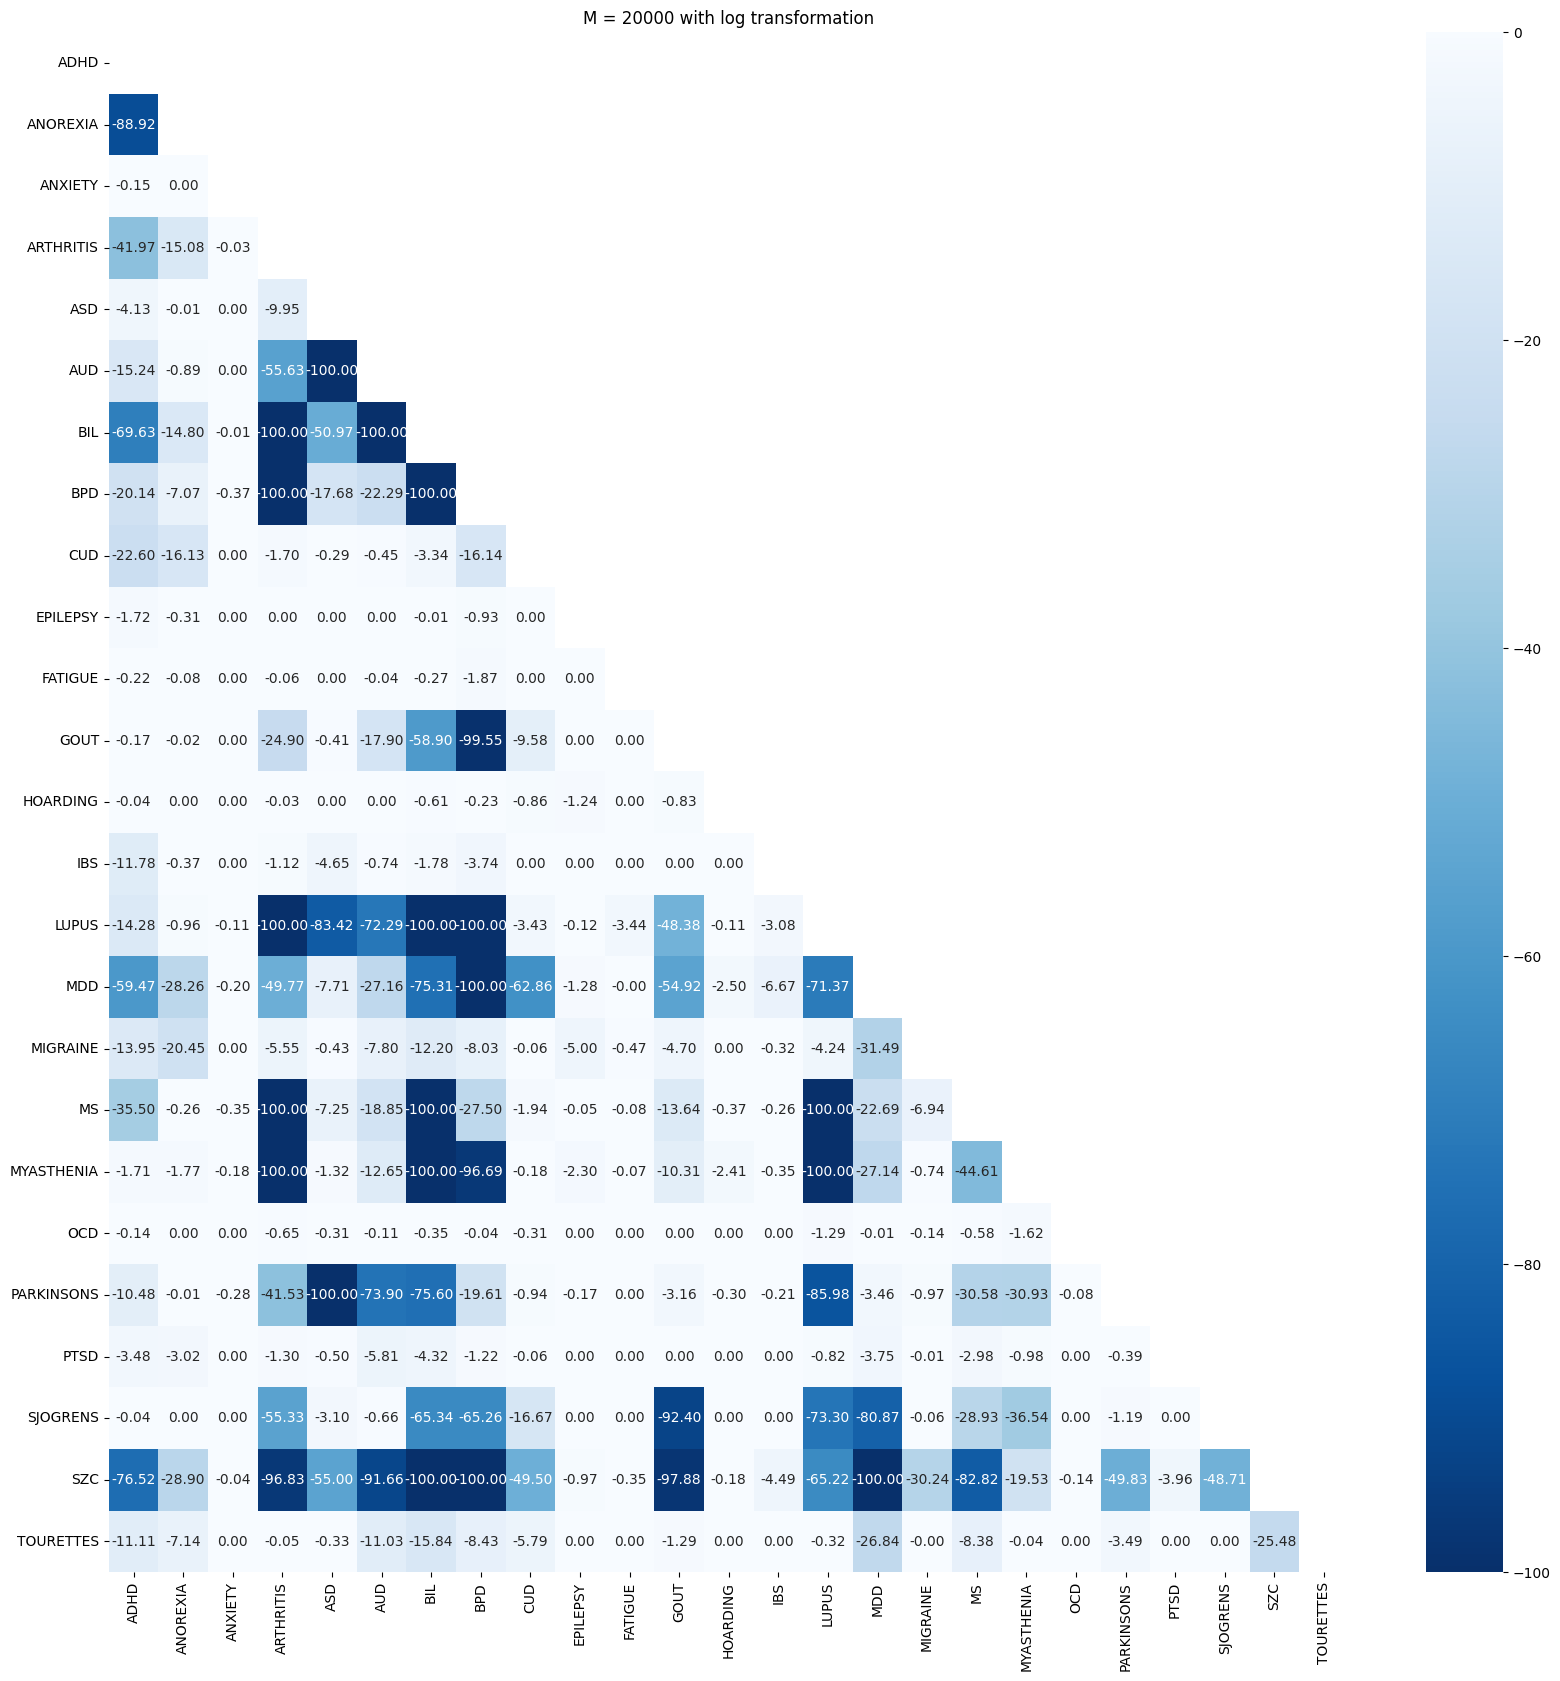

<Figure size 2000x1500 with 0 Axes>

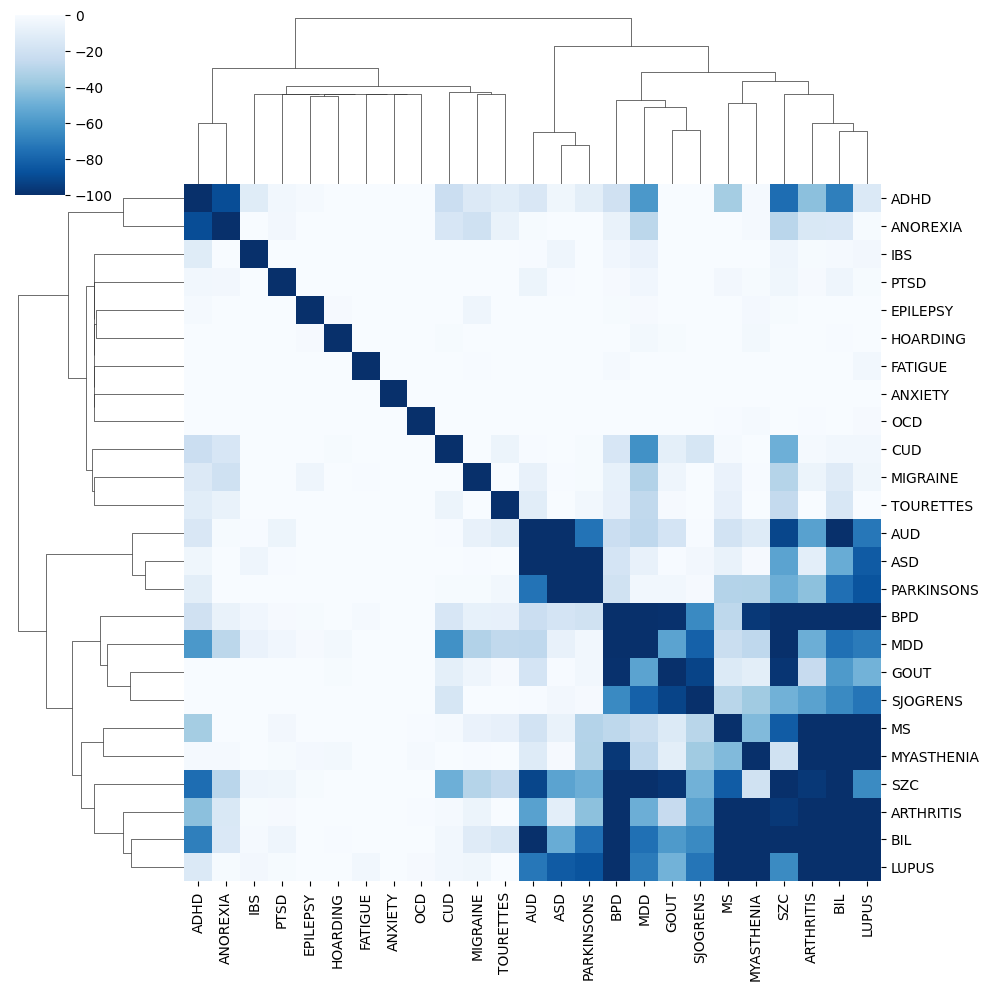

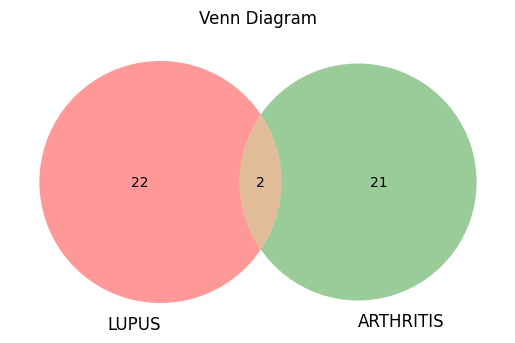

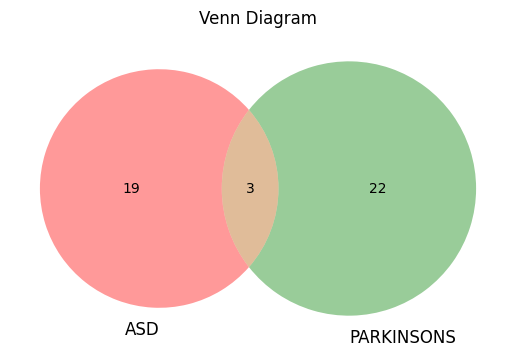

In [244]:
i = 10000
for df in genes_prob_list:
    
    # Create a mask for the upper triangular part
    mask = np.triu(np.ones_like(df, dtype=bool))

    # Set the upper triangular part to NaN to exclude it from the plot
    df = df.mask(mask)

    #Apply log transformation
    df_log = np.log10(df+1e-100)

    #reverse colormap
    cmap = 'Blues'
    cmap_reversed = cmap + '_r'
    
    fig, ax = plt.subplots(figsize=(20,20))
    plt.title(f'M = {i} with log transformation')
    sns.heatmap(df_log, annot=True,fmt='.2f',cmap=cmap_reversed, cbar=True)

    full_matrix = np.tril(df) + np.tril(df, -1).T

    full_df = pd.DataFrame(full_matrix, index=disorders, columns=disorders)
    full_df = full_df.fillna(1e-100)
    full_df_log = np.log10(full_df + 1e-100)
    plt.figure(figsize=(20,15))
    sns.clustermap(full_df_log,cmap=cmap_reversed)
    
    plt.show()
    venn_diagrams(full_df, 'LUPUS', 'ARTHRITIS')
    venn_diagrams(full_df, 'ASD', 'PARKINSONS')
    i+= 5000
    

In [ ]:
directory = 'KEGG/'

file_names = os.listdir(directory)
KEGG_dfs = []
# Iterate over each file
for file_name in file_names:
    # Check if the file is a text file
    if file_name.endswith('.txt'):
        # Read the file into a DataFrame
        file_path = os.path.join(directory, file_name)
        df = pd.read_csv(file_path, sep='\t')  # Assuming tab-separated
        
        # Extract disorder name from filename
        disorder_name = file_name.split('_')[2].split('.')[0]  # Extracting the disorder name
        
        # Add 'disorder' column with disorder name
        df['disorder'] = disorder_name
        KEGG_dfs.append(df)

In [ ]:
directory = 'Wiki_pathways/'

file_names = os.listdir(directory)
WIKI_dfs = []
# Iterate over each file
for file_name in file_names:
    # Check if the file is a text file
    if file_name.endswith('.txt'):
        # Read the file into a DataFrame
        file_path = os.path.join(directory, file_name)
        df = pd.read_csv(file_path, sep='\t')  # Assuming tab-separated
        
        # Extract disorder name from filename
        disorder_name = file_name.split('_')[2].split('.')[0]  # Extracting the disorder name
        
        # Add 'disorder' column with disorder name
        df['disorder'] = disorder_name
        WIKI_dfs.append(df)

In [ ]:
filtered_KEGG_dfs = []

for df in KEGG_dfs:
     # Split the 'Gene' column by ';' and count the number of genes in each row
    df['Gene Count'] = df['Genes'].str.count(';') + 1

    df = df[(df['Adjusted P-value'] < 0.05) & (df['Gene Count'] >= 5)]

    filtered_KEGG_dfs.append(df)



In [ ]:
filtered_WIKI_dfs = []

for df in WIKI_dfs:
     # Split the 'Gene' column by ';' and count the number of genes in each row
    df['Gene Count'] = df['Genes'].str.count(';') + 1

    df = df[(df['Adjusted P-value'] < 0.05) & (df['Gene Count'] >= 5)]

    filtered_WIKI_dfs.append(df)

In [ ]:
#Function to make binary matrix of SNPs and disorders
def make_binary_pathway_matrix(df_list):
    concatenated= pd.concat(df_list)
    df = concatenated[['Term', 'disorder']]
    
    return df.pivot_table(index='Term', columns='disorder', aggfunc=lambda x: 1, fill_value=0)

In [ ]:
KEGG_binary = make_binary_pathway_matrix(filtered_KEGG_dfs)
WIKI_binary = make_binary_pathway_matrix(filtered_WIKI_dfs)

In [ ]:
with open('Kegg_pathways_and_disorders.txt', 'w') as file:
    # Iterate over each row in the DataFrame
    for index, row in KEGG_binary.iterrows():
        # Get the disorders where the value is 1
        disorders_with_1 = row[row == 1].index.tolist()
        
        # Check if the number of disorders with 1 is at least 2
        if len(disorders_with_1) >= 2:
            # Get the 'Term' from the index (as it's now the index)
            term = index

            # Print the 'Term' and disorders
            file.write(f"{term}: {', '.join(disorders_with_1)}\n")

In [ ]:
with open('WIKI_pathways_and_disorders.txt', 'w') as file:
    # Iterate over each row in the DataFrame
    for index, row in WIKI_binary.iterrows():
        # Get the disorders where the value is 1
        disorders_with_1 = row[row == 1].index.tolist()
        
        # Check if the number of disorders with 1 is at least 2
        if len(disorders_with_1) >= 2:
            # Get the 'Term' from the index (as it's now the index)
            term = index

            # Print the 'Term' and disorders
            file.write(f"{term}: {', '.join(disorders_with_1)}\n")

In [329]:

adhd_anorex_path = pd.read_csv('Wiki_pathways\WikiPathway_2023_adhd_anorexia.txt', sep='\t')
adhd_anorex_path['Gene Count'] = adhd_anorex_path['Genes'].str.count(';') + 1
adhd_anorex_path = adhd_anorex_path[(adhd_anorex_path['Adjusted P-value'] < 0.05) & (adhd_anorex_path['Gene Count'] >= 5)]

adhd_anorex_KEGG = pd.read_csv('KEGG\KEGG_2021_adhd_anorexia.txt', sep='\t')
adhd_anorex_KEGG['Gene Count'] = adhd_anorex_KEGG['Genes'].str.count(';') + 1
adhd_anorex_KEGG = adhd_anorex_KEGG[(adhd_anorex_KEGG['Adjusted P-value'] < 0.05) & (adhd_anorex_KEGG['Gene Count'] >= 5)]

In [346]:
adhd_anorex_path
#adhd_anorex_KEGG

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Gene Count


In [332]:
aud_asd_park_path = pd.read_csv('Wiki_pathways\WikiPathway_2023_aud_asd_parkinsons.txt', sep='\t')
aud_asd_park_path['Gene Count'] = aud_asd_park_path['Genes'].str.count(';') + 1
aud_asd_park_path = aud_asd_park_path[(aud_asd_park_path['Adjusted P-value'] < 0.05) & (aud_asd_park_path['Gene Count'] >= 5)]

aud_asd_park_KEGG = pd.read_csv('KEGG\KEGG_2021_aud_asd_parkinsons.txt', sep='\t')
aud_asd_park_KEGG['Gene Count'] = aud_asd_park_KEGG['Genes'].str.count(';') + 1
aud_asd_park_KEGG = aud_asd_park_KEGG[(aud_asd_park_KEGG['Adjusted P-value'] < 0.05) & (aud_asd_park_KEGG['Gene Count'] >= 5)]


In [345]:
aud_asd_park_path
#aud_asd_park_KEGG

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Gene Count


In [335]:
bpd_szc_path = pd.read_csv('Wiki_pathways\WikiPathway_2023_szc_bpd.txt',sep='\t')
bpd_szc_path['Gene Count'] = bpd_szc_path['Genes'].str.count(';') + 1
bpd_szc_path = bpd_szc_path[(bpd_szc_path['Adjusted P-value'] < 0.05) & (bpd_szc_path['Gene Count'] >= 5)]

bpd_szc_KEGG = pd.read_csv('KEGG\KEGG_2021_szc_bpd.txt',sep='\t')
bpd_szc_KEGG['Gene Count'] = bpd_szc_KEGG['Genes'].str.count(';') + 1
bpd_szc_KEGG = bpd_szc_KEGG[(bpd_szc_KEGG['Adjusted P-value'] < 0.05) & (bpd_szc_KEGG['Gene Count'] >= 5)]

In [344]:
bpd_szc_path
#bpd_szc_KEGG

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Gene Count
0,15Q25 Copy Number Variation WP5408,21/45,3.574686e-13,2.262776e-10,0,0,11.786802,337.806550,SH3GL3;NMB;ZNF592;BNC1;HOMER2;C15ORF40;ITPR1;W...,21
1,8P23 1 Copy Number Variation Syndrome WP5346,21/52,1.130412e-11,3.577754e-09,0,0,9.121827,229.923448,BLK;TNKS;PINX1;SLC35G5;MTMR9;PRSS55;MTMR7;HSPD...,21
2,2Q11 2 Copy Number Variation Syndrome WP5221,16/32,6.280618e-11,1.325210e-08,0,0,13.427746,315.430739,ANKRD39;LMAN2L;ARID5A;ADRA2B;NCAPH;CIAO1;FAM17...,16
3,16P11 2 Proximal Deletion Syndrome WP4949,19/74,5.279826e-07,8.355324e-05,0,0,4.638997,67.052999,INO80E;PRRT2;DOC2A;MVP;QPRT;GDPD3;TBX6;SEZ6L2;...,19


In [338]:
gout_sjogrens_path = pd.read_csv('Wiki_pathways\WikiPathway_2023_gout_sjogrens.txt', sep='\t')
gout_sjogrens_path['Gene Count'] = gout_sjogrens_path['Genes'].str.count(';') + 1
gout_sjogrens_path = gout_sjogrens_path[(gout_sjogrens_path['Adjusted P-value'] < 0.05) & (gout_sjogrens_path['Gene Count'] >= 5)]

gout_sjogrens_KEGG = pd.read_csv('KEGG\KEGG_2021_gout_sjogrens.txt', sep='\t')
gout_sjogrens_KEGG['Gene Count'] = gout_sjogrens_KEGG['Genes'].str.count(';') + 1
gout_sjogrens_KEGG = gout_sjogrens_KEGG[(gout_sjogrens_KEGG['Adjusted P-value'] < 0.05) & (gout_sjogrens_KEGG['Gene Count'] >= 5)]

In [340]:
gout_sjogrens_path
#gout_sjogrens_KEGG

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Gene Count


In [341]:
autoimmune_path = pd.read_csv('Wiki_pathways\WikiPathway_2023_myasthenia_bil_lupus_ms_arthritis.txt',sep='\t')
autoimmune_path['Gene Count'] = autoimmune_path['Genes'].str.count(';') + 1
autoimmune_path = autoimmune_path[(autoimmune_path['Adjusted P-value'] < 0.05) & (autoimmune_path['Gene Count'] >= 5)]

autoimmune_KEGG = pd.read_csv('KEGG\KEGG_2021_myasthenia_bil_lupus_ms_arthritis.txt',sep='\t')
autoimmune_KEGG['Gene Count'] = autoimmune_KEGG['Genes'].str.count(';') + 1
autoimmune_KEGG = autoimmune_KEGG[(autoimmune_KEGG['Adjusted P-value'] < 0.05) & (autoimmune_KEGG['Gene Count'] >= 5)]

In [343]:
autoimmune_path
#autoimmune_KEGG

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Gene Count
0,Extrafollicular And Follicular B Cell Activati...,5/74,0.000042,0.006650,0,0,14.512516,146.318899,CD79A;MAF;BACH2;CD22;TNFSF13B,5
3,Allograft Rejection WP2328,5/90,0.000107,0.006650,0,0,11.771242,107.640011,IL1B;IL2RA;PRF1;CTLA4;FOXP3,5
4,CKAP4 Signaling Pathway Map WP5322,5/109,0.000263,0.013081,0,0,9.611500,79.242962,CD74;CASP5;CASP4;LEF1;MAPK14,5
